# Imports and Functions

In [119]:
import utlt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy import stats
from scipy import fftpack
from scipy.signal import find_peaks, hilbert, windows, blackman, stft
from scipy.integrate import simps
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.linalg import lstsq, eigh, norm
from scipy.optimize import curve_fit, nnls, leastsq, minimize, least_squares
from scipy.constants import hbar, elementary_charge, speed_of_light, Boltzmann

from itertools import product, combinations
import copy
from split_op_gpe1D import SplitOpGPE1D, imag_time_gpe1D    # class for the split operator propagation
from numba import njit

from collections import Counter
from dataclasses import dataclass

from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm


from sklearn import linear_model

import glob
import os

from datetime import datetime

threads = 16
os.environ["OMP_NUM_THREADS"] = '{}'.format(threads)
os.environ['NUMEXPR_MAX_THREADS'] = '{}'.format(threads)
os.environ['NUMEXPR_NUM_THREADS'] = '{}'.format(threads)
os.environ['OMP_NUM_THREADS'] = '{}'.format(threads)
os.environ['MKL_NUM_THREADS'] = '{}'.format(threads)

In [2]:
def order(number):
    return np.floor(np.log10(number))


def get_wide_plot(parameters=plt.rcParams):
    wide_plt_params = {
        'figure.figsize': (4, 3),
        'figure.dpi': 300,
        'legend.fontsize': 7,
        'axes.labelsize': 10,
        'axes.titlesize': 8,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'lines.linewidth': 2,
    }
    parameters.update(wide_plt_params)


def Phi(grid, wave_vector, phase=0, amplitude=1):
    return amplitude * np.sin(wave_vector * grid + phase)


def Phi_transform(time, frequency, amplitude_1, amplitude_2):
    return amplitude_1 * np.sin(frequency * time) + amplitude_2 * np.cos(frequency * time)


def Phi_combine(A, B, wave_vector, grid):
    amplitude = np.sqrt(A ** 2 + B ** 2)
    phase = np.angle(A + 1j * B)
    single_field = amplitude * np.cos(wave_vector * grid - phase)
    return amplitude, phase, single_field


def Phi_combine_amps(A, B):
    """
    Remember that A is the amplitude of the COSINE
    and B is the amplitude of the SINE
    """
    return  np.sqrt(A ** 2 + B ** 2)


def Phi_combine_phases(A, B):
    return np.angle(A + 1j * B)


def atomic_transition(x='D1'):
    """
    I hated how the code looked commenting and uncommenting so, I've simply stuck this here in initial functions
    Is this necessary? No, but also I don't care.
    """
    common_transitions = {
        'D1': 794.978851,
        'D2': 780.251210,
    }
    return common_transitions[x]


ok = utlt.standardize_plots(plt.rcParams)

In [3]:
"""
Determine the atomic transition line, D1 or D2 lines for Rb-87 are the only ones supported currently
Then, call an instance of BEC to get physical params. 
This way wavelengths may be set precisely for dimensionless units.
Additionally this cell enables polarizability calculations for translating field strength to potential amplitude.
"""

transition = 'D2'
principal_wavelength = atomic_transition(transition)
# Resonance frequency of the atomic transition in units of 2π Hz to keep units consistent,
ω_0 = 2 * np.pi * speed_of_light / principal_wavelength * 1e9
print(f'As expected, the target transition frequency is 2π {ω_0 / (2 * np.pi) * 1e-12} THz')
# Model parameters for dimensionless units.
ω_x = 0.25 * 2 * np.pi  # From experimental cigar length params
ω_yz = 500 * 2 * np.pi
N = 2e3

atom_params = dict(
    atom='R87',
    kicked=False,
    omega_x=ω_x,
    omega_y=ω_yz,
    omega_z=ω_yz,
    number_of_atoms=N,
)
gpe = utlt.BEC(**atom_params)
g = gpe.g


def get_alpha(wavelength):
    """Function to determine the scaling coefficient to translate electric field to optical potential
    It is VERY IMPORTANT to pass the wavelength in nm!!!
    """
    frequency = 2 * np.pi * speed_of_light * 1e9 / wavelength
    denominator = ω_0 ** 2 - frequency ** 2
    # This is the prefactor e^2/m, which is of the total order 10^-13
    prefactor = 1.602176634 ** 2 / 1.44316060
    gfo = order(np.abs(denominator))
    denominator /= 10 ** gfo
    alpha_order = -13 - gfo
    return prefactor / denominator, alpha_order


def get_dimless_alpha(wavelength):
    """Function to determine the scaling coefficient to translate electric field to optical potential
    It is VERY IMPORTANT to pass the wavelength in nm!!!
    """
    # Here we apply convert_time intead of dimless time because frequency is inverse time
    frequency = gpe.convert_time(2 * np.pi * speed_of_light * 1e9 / wavelength, 0)
    denominator = gpe.convert_time(ω_0, 0) ** 2 - frequency ** 2
    gfo = order(np.abs(denominator))
    denominator /= 10 ** gfo
    return 1 / denominator, -gfo


def f2V_scaling(wavelength):
    """
    Function to determine the scaling coefficient to translate electric field to optical potential
    It is VERY IMPORTANT to pass the wavelength in meters!!!
    """
    frequency = 2 * np.pi * speed_of_light / wavelength 
    gfo = order(frequency)
    frequency /= 10 ** gfo
    ω0_orderless = ω_0 / 10 ** gfo
    α = 1.602176634 ** 2 / 1.4431606    # the order of magnitude, 10^-13, will be added in the next line.
    return (0.5 * α / (ω0_orderless ** 2 - frequency ** 2)), (-13 - (gfo * 2))

def two_field_combine(E0, E1, λ1, λ2):
    α1, α1_order = get_alpha(λ1)
    α1 *= 10 ** α1_order
    α2, α2_order = get_alpha(λ2)
    α2 *= 10 ** α2_order
    potential = α1 * E0 ** 2 + α2 * E1 ** 2 + (α1 + α2) * (E0 * E1)
    return potential, (α1 + α2) * (E0 * E1)


def full_field_decomp(grid, ϕ1, ϕ2, λ1, λ2, a1, a2):
    """
    The assumption here is that you're passing λ's in nm, this function will handle dimensionless conversion.
    """
    α1, α1_order = get_dimless_alpha(λ1)
    α2, α2_order = get_dimless_alpha(λ2)
    # Because λ1 should be passed as the wavelength further from resonance
    # We get the difference in order starting with the smaller order to make bigger numbers
    α_order_diff = α1_order - α2_order
    α1 *= 10 ** α_order_diff
    k1 = 2 * np.pi / gpe.dimless_x(λ1, -9)
    k2 = 2 * np.pi / gpe.dimless_x(λ2, -9)
    EV1 = -α1 * (a1 * np.cos(k1 * grid - ϕ1)) ** 2
    EV2 = -α2 * (a2 * np.cos(k2 * grid - ϕ2)) ** 2 
    Δk = k1 - k2
    Δϕ = ϕ1 - ϕ2
    Σk = k1 + k2
    Σϕ = ϕ1 + ϕ2
    cross_term_coeff = 0.5 * (α1 + α2)
    coeff_order = α2_order
    envelope_term = -cross_term_coeff * a1 * a2 * np.cos(Δk * grid - Δϕ)
    so_term = -cross_term_coeff * a1 * a2 * np.cos(Σk * grid - Σϕ)
    return {'potential': EV1 + EV2 + envelope_term + so_term,
            'fields': [EV1, EV2, envelope_term, so_term],
            'field_orders': [α2_order, α2_order, α2_order, α2_order],
            'alphas': [[α1, α1_order], [α2, α2_order]],
            'cross_term': [cross_term_coeff, coeff_order],
            'coeffs': {
                'k1':k1,
                'k2':k2,
                'Δk': Δk,
                'Δϕ': Δϕ,
                'Σk': Σk,
                'Σϕ': Σϕ,},
           }


def get_V(grid, ϕ1, ϕ2, λ1, λ2, a1, a2, units='K'):
    """
    The assumption here is that you're passing λ's in nm.
    If you need the potential in Joules, pass units as 'J'
    """
    α1, α1_order = get_alpha(λ1)
    α2, α2_order = get_alpha(λ2)
    # Because λ1 should be passed as the wavelength further from resonance
    # We get the difference in order starting with the smaller order to make bigger numbers
    α_order_diff = α1_order - α2_order
    α1 *= 10 ** α_order_diff
    k1 = 2 * np.pi * 1e9 / λ1
    k2 = 2 * np.pi * 1e9 / λ2
    EV1 = (a1 * np.cos(k1 * grid - ϕ1))
    EV2 = (a2 * np.cos(k2 * grid - ϕ2))
    potential = -α1 * EV1 ** 2 - α2 * EV2 ** 2 - (α1 + α2) * EV1 * EV2
    if units == 'K':
        potential /= 1.380649
        nkvo = 32 + α2_order
        return potential, nkvo                                  
    else:                               
        return potential, α2_order

As expected, the target transition frequency is 2π 384.225559868084 THz


# Params defined here

In [188]:
"""
Define Laser Params and the simulation grid
"""
# Control Amplitudes (in nm)
λ_control = np.array([900, 1350])
#λ_control = np.array([702, 780])
λ_min = min(λ_control)
# Target wavelength (equal to the width of the superoscillations window)
λ_target = 0.25 * min([principal_wavelength, λ_min])  # 0.2*
#λ_target = 0.25 * λ_min
# Wavevectors in dimensionless units for computation purposes
k_target = 2 * np.pi / gpe.dimless_x(λ_target, -9)
k = 2 * np.pi * (gpe.dimless_x(λ_control, -9) ** -1)

# Set the dimensionless length of the window for superoscillations here
window = gpe.dimless_x(λ_target, -9)
# Limit the full range of pulse to the characteristic length
x_lim = gpe.dimless_x(np.lcm(λ_control[0], λ_control[1]) / 2, -9)
#x_lim = gpe.dimless_x(np.lcm(int(4*λ_control[0]), int(4*λ_control[1])) / 8, -9)
print(f'Compare the characteristic length {gpe.L_x*1e6} μm vs the full window length: {2 * gpe.convert_x(x_lim, -6)} μm')
x_res = 2 ** 15
dx = 2 * x_lim / x_res

x = np.arange(-window/2, window/2, dx)
x_full = np.arange(-x_lim, x_lim, dx)
x_units = gpe.convert_x(x, -9)
x_unitz = gpe.convert_x(x_full, -9)


# Number of pulses
n = len(λ_control)
# Determine the error tolerance
eps = 1e-11
# Amplitude of target barrier
ampl = np.sqrt(gpe.dimless_energy(600, -9))
# For if you wish to pre-cool the BEC in a centered quadratic potential
pre_cooling = False

Compare the characteristic length 21.5685408388234 μm vs the full window length: 2.7 μm


In [189]:
named_params = {
    'window_length': round(λ_target, 5),
    'max': round(max(λ_control), 5),
    'min': round(min(λ_control), 5),
    'precool': pre_cooling,
}
if λ_min > principal_wavelength:
    beamcolor= 'Red'
else:
    beamcolor = 'Blue'
params = copy.deepcopy(named_params)
file_path, file_name = utlt.build_saves_tag(params_list=named_params,
                                            unique_identifier=f'Testing_{transition}-{beamcolor}-TwoPulseExperiment',
                                            parent_directory='Archive_Data/Superoscilations')

Parent directory check passed! 
Results will be available in Archive_Data/Superoscilations

Simulation Directory "Testing_D2-Red-TwoPulseExperiment-window_length195,0628-max1350-min900-precoolFalse" created


In [190]:
############################################################
#
# It is important to calculate the Critical Temp for a BEC
# This ensures that simulations are actually a BEC, and not
# just wishful thinking. 
#
# T_c = (number density / ζ(3/2))^(2/3) * 2πħ^2 / m*kB
#
############################################################

# The volume in micrometers temporarily to avoid machine precision
# These changes to order of magitude are corrected for by removing orders of known quantities
# ħ = 1.054571817e-34, kB=1.380649e-23*1e-9nK/K, m_87Rb=1.4431609e-25, L_i∝1e-6, Volume∝1e-18
# (N/∝1e-18)^(2/3) → (N/orderless_volume)^(2/3)*1E02, 
# simply multiplying by orders, we get 1E02 * ((1e-34)^2 / (1e-23*1e-9*1e-25)) → 1E02 * 1e57 / 1e68 → 1E0, 10
volume = (gpe.L_x * 1e6) * (gpe.L_y * 1e6) * (gpe.L_z * 1e6)
number_density = N / volume 
ζ_32 = 2.61237534869    # Riemman Zeta function (3/2)
T_c = 10 * (number_density / ζ_32) ** (1.5) * 2 * np.pi * 1.054571817 ** 2 / (1.4431609 * 1.380649)


# Now print the parameters for the run so that simulations can guarantee T << T_c
print(f'T_c, the critical temperature, is {T_c} nK.\nThis will be checked when modeling experiment')
#print(f'The wavelength spacing is {λ_spacing * gpe.convert_x(λ_min, -9)} nm') # Not used currently
print(f'The conversion factor for dimensionless energy {gpe.dimless_energy(1, -9)}')
print(f'The target potential amplitude is {round(gpe.convert_energy(ampl ** 2, -9), 2)} nK, or ~{round(ampl ** 2, 2)} in dimensionless units.')
print(f'The characteristic length, L_x is {gpe.L_x *1e6} μm')
print(f'The transverse characteristic length, L_y, L_z is {gpe.L_y *1e6} μm')
print(f'The shortest wavelength for this for this run is {min(λ_control)} nm')

T_c, the critical temperature, is 66111.54888998118 nK.
This will be checked when modeling experiment
The conversion factor for dimensionless energy 83.3464764933103
The target potential amplitude is 600.0 nK, or ~50007.89 in dimensionless units.
The characteristic length, L_x is 21.5685408388234 μm
The transverse characteristic length, L_y, L_z is 0.48228723491089454 μm
The shortest wavelength for this for this run is 900 nm


In [191]:
target_barrier = Phi(x, k_target, amplitude = ampl, phase=-np.pi/2)   
get_alpha(min(λ_control))

(1.2286086007625978, -43.0)

## Solving the eigenvalue equation begins here


In [192]:
#########################################################################
#
# Alternate option, generating best fields by solving eigenvalue problem
#
#########################################################################
dim_α1, dim_α1_order = get_alpha(λ_control[0])
dim_α2, dim_α2_order = get_alpha(λ_control[1])
α1 = gpe.dimless_energy(dim_α1, dim_α1_order, units='J')
α2 = gpe.dimless_energy(dim_α2, dim_α2_order, units='J')
α2_order = order(np.abs(α2))
α1 *= 10 ** (-α2_order)
α2 *= 10 ** (-α2_order)
#α_order_diff = α1_order - α2_order
#α1 *= 10 ** α_order_diff 
print(α1)
print(α2)
E0 = np.sin(k[0]*x)
f0 = np.sin(k[0]*x_full)
E1 = np.cos(k[0]*x)
f1 = np.cos(k[0]*x_full)
E2 = np.sin(k[1]*x)
f2 = np.sin(k[1]*x_full)
E3 = np.cos(k[1]*x)
f3 = np.cos(k[1]*x_full)

# create the quadratic form matrix
S = 0.5 * np.array([[α1*simps(E0*E0, dx=dx), α1*simps(E0*E1, dx=dx), 
                        0.5*(α1 + α2)*simps(E0*E2, dx=dx), 0.5*(α1 + α2)*simps(E0*E3, dx=dx)],
                   [α1*simps(E1*E0, dx=dx), α1*simps(E1*E1, dx=dx), 
                        0.5*(α1 + α2)*simps(E1*E2, dx=dx), 0.5*(α1 + α2)*simps(E1*E3, dx=dx)],
                   [0.5*(α1 + α2)*simps(E0*E2, dx=dx), 0.5*(α1 + α2)*simps(E1*E2, dx=dx), 
                        α2*simps(E2*E2, dx=dx), α2*simps(E2*E3, dx=dx)],
                   [0.5*(α1 + α2)*simps(E0*E3, dx=dx), 0.5*(α1 + α2)*simps(E1*E3, dx=dx), 
                        α2*simps(E2*E3, dx=dx), α2*simps(E3*E3, dx=dx)]])



# Solve the eigenvalue problem
vals, vecs = eigh(S)


7.416816139579192
2.7665030265185324


In [193]:
#########################################################################
#
# Alternate option, generating best fields by solving eigenvalue problem
#
#########################################################################
m = k[0] - k[1]
p = k[0] + k[1]
xi = -0.5 * window
xf = 0.5 * window
# window = gpe.dimless_x(λ_target, -9)
print(f'xi: {xi}, xf: {xf}')

# This notation is awful and I don't care
a1a1 = α1 * (0.5 * window - (np.sin(2 * k[0] * xf) - np.sin(2 * k[0] * xi)) / (4 * k[0]))
a2a2 = α1 * (0.5 * window + (np.sin(2 * k[0] * xf) - np.sin(2 * k[0] * xi)) / (4 * k[0]))
a3a3 = α2 * (0.5 * window - (np.sin(2 * k[1] * xf) - np.sin(2 * k[1] * xi)) / (4 * k[1]))
a4a4 = α2 * (0.5 * window + (np.sin(2 * k[1] * xf) - np.sin(2 * k[1] * xi)) / (4 * k[1]))
a1a2 = a2a1 = α1 * ((np.sin(k[0] * xf) ** 2 - np.sin(k[0] * xi) ** 2) / (2 * k[0]))
a3a4 = a4a3 = α2 * ((np.sin(k[1] * xf) ** 2 - np.sin(k[1] * xi) ** 2) / (2 * k[1]))
a1a3 = a3a1 = 0.5 * (α1 + α2) * ((np.sin(m * xf) / (2 * m) - np.sin(p * xf) / (2 * p)) 
                                 - (np.sin(m * xi) / (2 * m) - np.sin(p * xi) / (2 * p)))
a2a4 = a4a2 = 0.5 * (α1 + α2) * ((np.sin(m * xf) / (2 * m) + np.sin(p * xf) / (2 * p)) 
                                 - (np.sin(m * xi) / (2 * m) + np.sin(p * xi) / (2 * p))) 
a1a4 = a4a1 = 0
a2a3 = a3a2 = 0

Ss = 0.5 * np.array([[a1a1, a1a2, a1a3, a1a4], 
               [a2a1, a2a2, a2a3, a2a4],
               [a3a1, a3a2, a3a3, a3a4],
               [a4a1, a4a2, a4a3, a4a4]])
valss, vecss = eigh(Ss)


xi: -0.004521928580093993, xf: 0.004521928580093993


In [194]:
print(f'1: {α1}, 2: {α2}, order: 1e{int(α2_order)}')
print(vals)
print(valss)
print(vecss[:, 2])

1: 7.416816139579192, 2: 2.7665030265185324, order: 1e-10
[-0.00206727 -0.00017899  0.00572437  0.04256352]
[-0.0020675  -0.00017906  0.0057267   0.04256811]
[0.91108057 0.         0.41222832 0.        ]


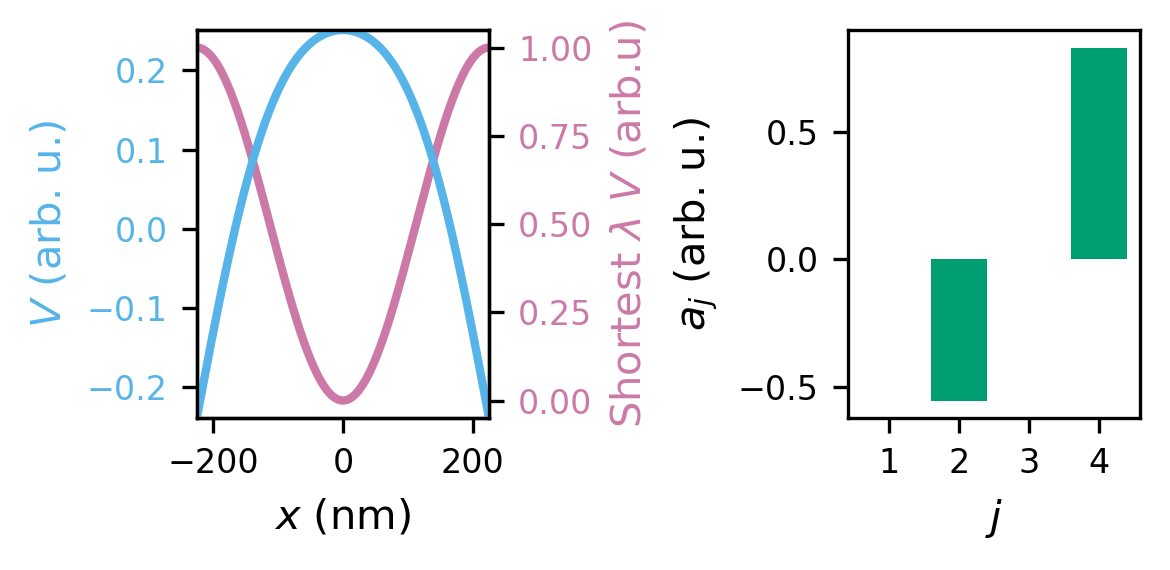

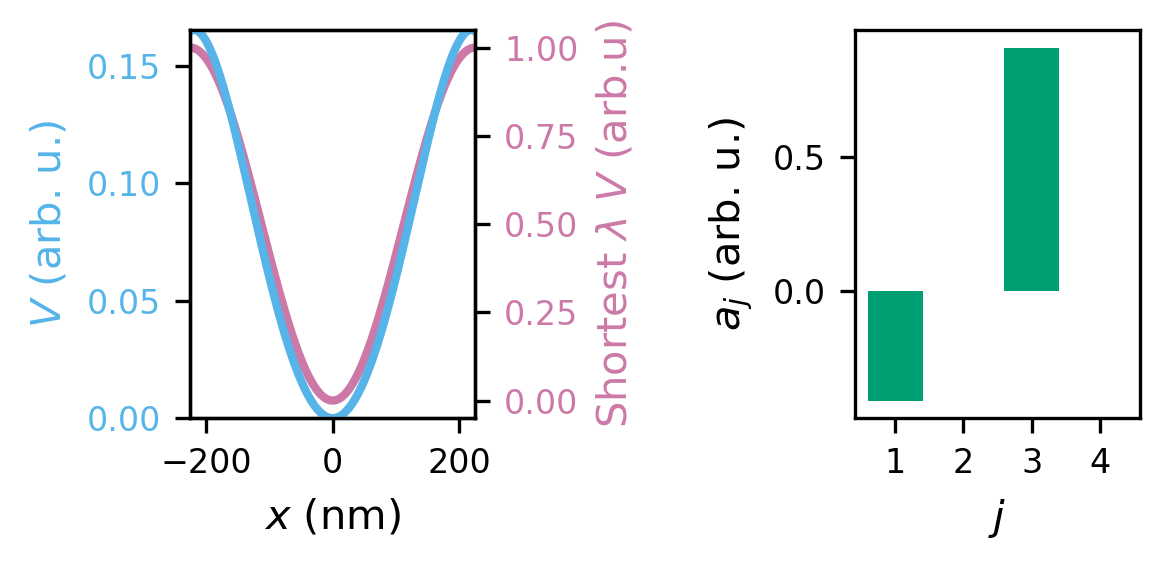

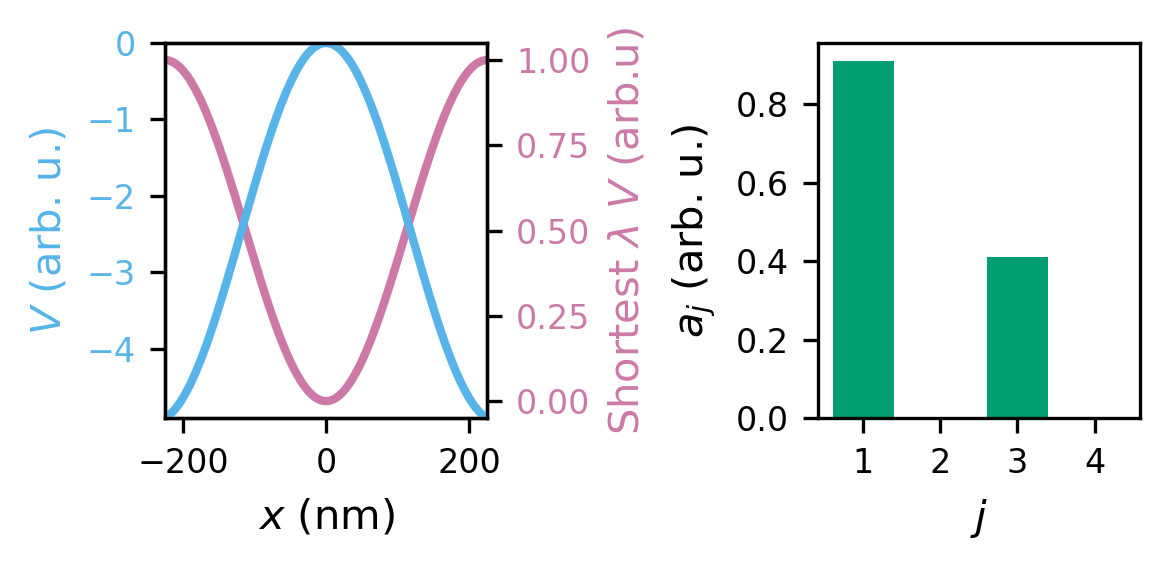

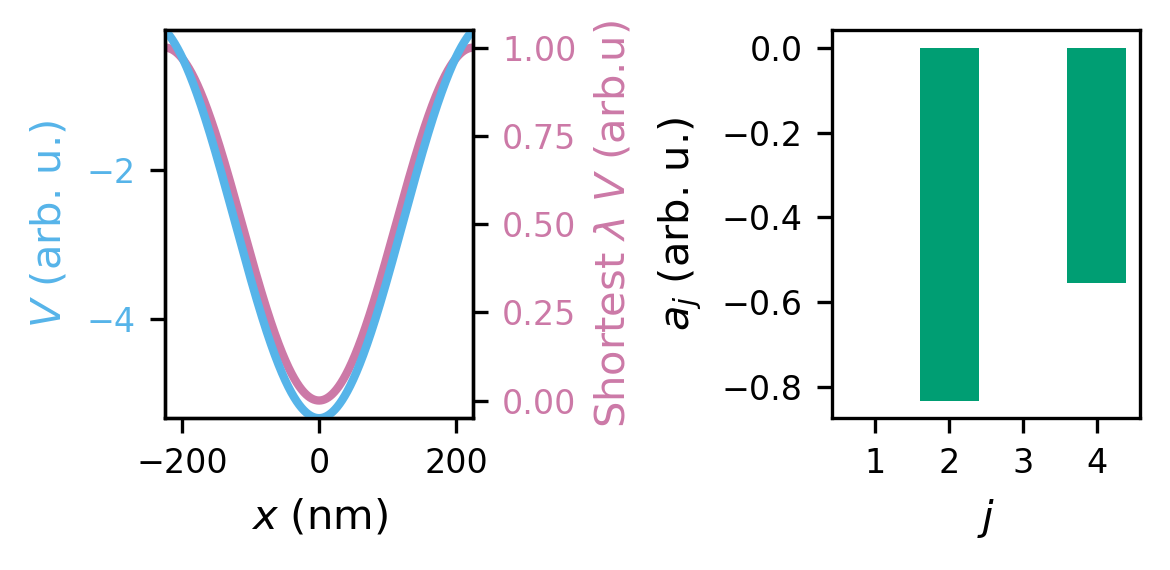

In [195]:
k_max = max(k)
largest_freq_pulse = Phi(x, max(k)) #, phase=np.pi/2)
largest_freq_pulsez = Phi(x_full, max(k)) #, phase=np.pi/2)
bounded = [-0.25 * λ_min, 0.25 * λ_min]


c1 = ok['blue']
c2 = ok['purple']
c3 = ok['green']
c4 = ok['amber']
c5 = ok['red']

get_wide_plot(plt.rcParams)

for _ in range(n*2):
    #fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(8, 3), dpi=300)
    fig, (ax1, ax1__) = plt.subplots(1, 2, figsize=(4,2))
    eig_vector=vecs[:, _]
    tector=vecss[:, _] 
    tV = np.array(-0.5 * (α1 * (tector[0] * f0 + tector[1] * f1) ** 2 + α2 * (tector[2] * f2 + tector[3] * f3) ** 2
                     + (α1 + α2) * (tector[0] * f0 + tector[1] * f1) * (tector[2] * f2 + tector[3] * f3)))
    rat_wind = 0.5 * λ_min / λ_target
    ampl_ind = [int(0.5 * (len(x_full) - rat_wind * len(x))), int(0.5 * (len(x_full) + rat_wind * len(x)))]
    ampl_ref = [min(tV[ampl_ind[0]:ampl_ind[1]]), max(tV[ampl_ind[0]:ampl_ind[1]])]
    #ax1.plot(x, tempV, color=c1)
    ax1.plot(x_unitz, tV, color=c1)  #, color=c4, linestyle='--')
    
    ax1.set_ylabel('$V$ (arb. u.)', color=c1)
    ax1.tick_params(axis='y', labelcolor=c1)
    ax1.set_xlim(bounded)
    ax1.set_ylim(ampl_ref)

    ax1.set_xlabel('$x$ (nm)')
    
    ax2 = ax1.twinx() 

    ax2.plot(x_unitz, largest_freq_pulsez ** 2, color=c2)
    ax2.set_ylabel('Shortest $\lambda$ $V$ (arb.u)', color=c2)
    ax2.tick_params(axis='y', labelcolor=c2)    
    ax1.set_zorder(1)
    ax1.patch.set_visible(False)

    # plot pulses
    ax1 = ax1__
    
    ax1.bar(np.arange(1, 2*n+1, 1), eig_vector, color=c3)
    #bar_width=0.75*(k[1]-k[0])
    #ax1.bar(k, combined_eig_vecs, width=bar_width, color=c4)
    #ax1.set_xticks(k)
    ax1.set_xticks(np.arange(1, 2*n+1, 1))
    #ax1.set_ylim(0.995 * min(combined_eig_vecs), 1.005 * max(combined_eig_vecs))
    ax1.set_xlabel('$j$')
    ax1.set_ylabel('$a_{j}$ (arb. u.)')
    
    fig.tight_layout()
    plt.savefig(f'{file_path}/{file_name}_aBa_EigenvectorSolution{_}.pdf')

plt.show()

ok=utlt.standardize_plots(plt.rcParams)

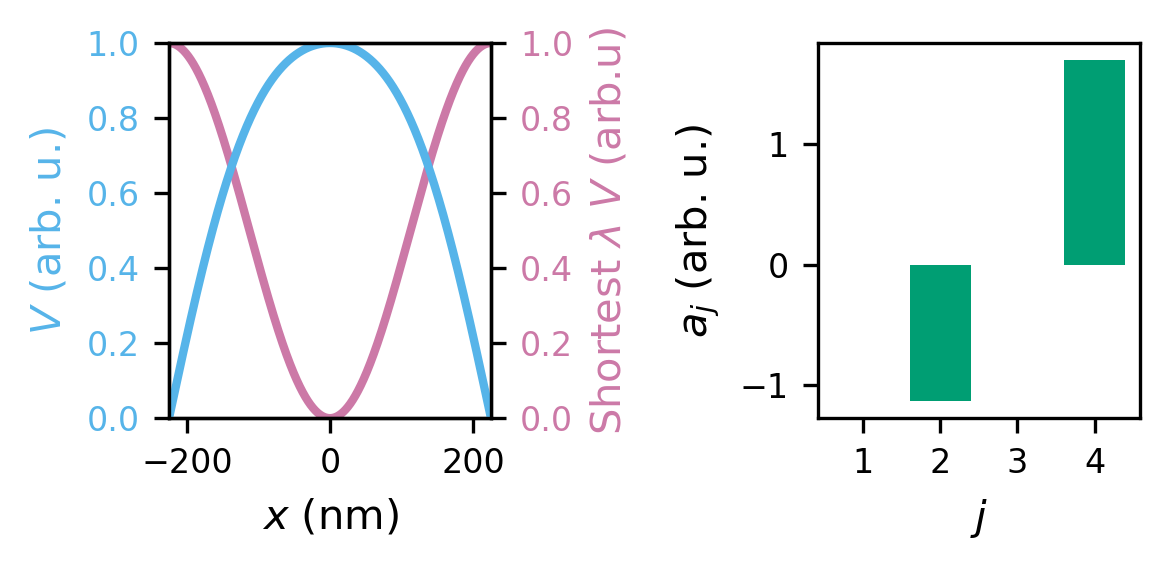

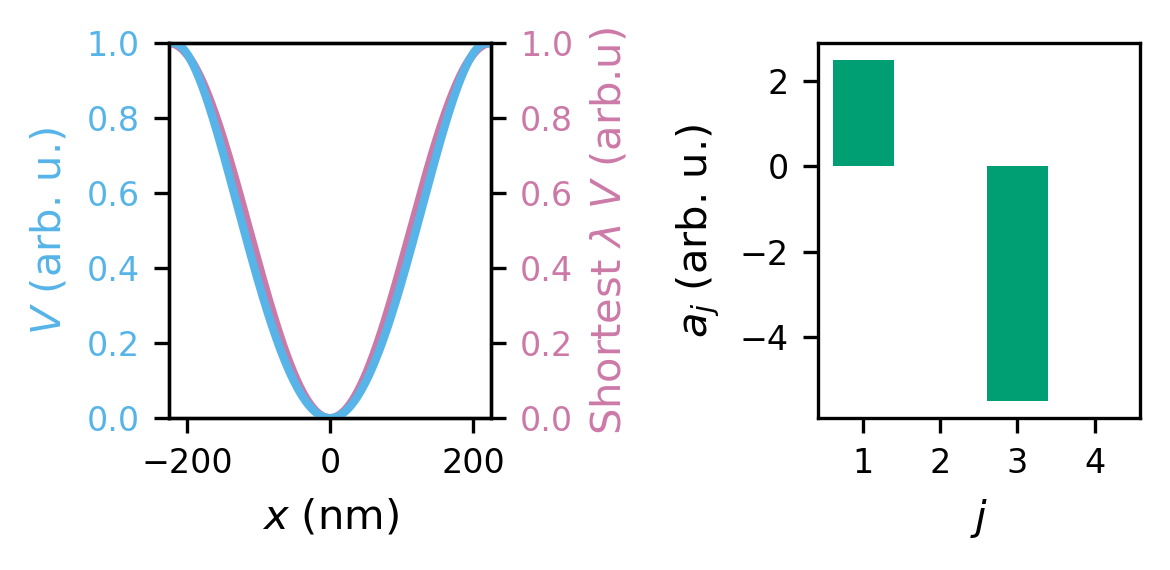

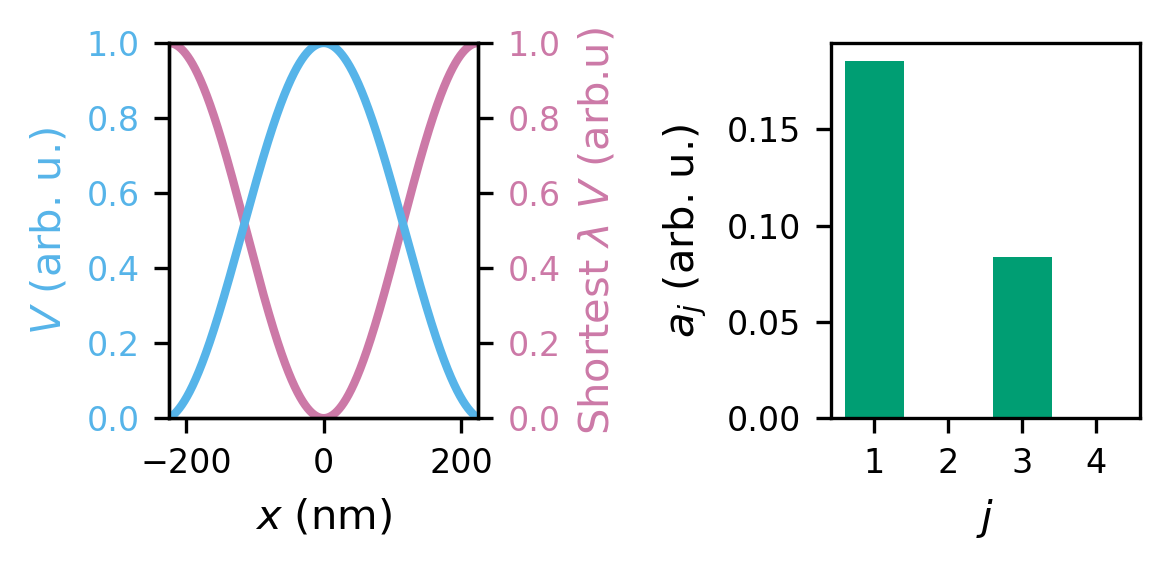

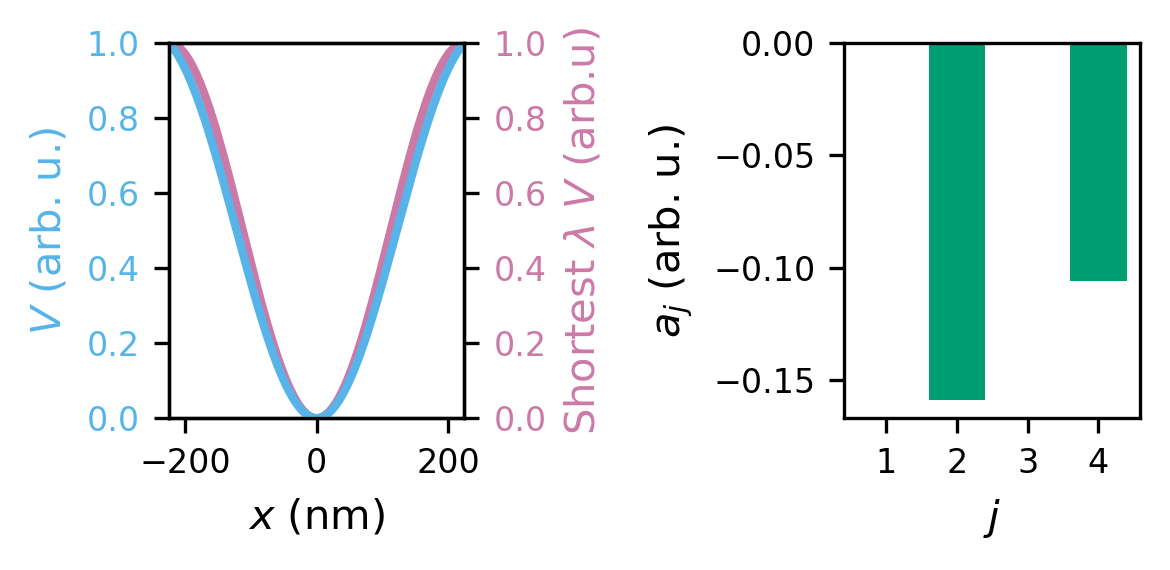

In [196]:
# Proper Comparison
for _ in range(n*2):
    fig, (ax1, ax1__) = plt.subplots(1, 2, figsize=(4,2))
    eig_vector=vecs[:, _]
    tector=vecss[:, _] 
    tV = np.array(-0.5 * (α1 * (tector[0] * f0 + tector[1] * f1) ** 2 + α2 * (tector[2] * f2 + tector[3] * f3) ** 2
                     + (α1 + α2) * (tector[0] * f0 + tector[1] * f1) * (tector[2] * f2 + tector[3] * f3)))
    l = np.where(x_unitz >= -0.25 * λ_min)[0][0]
    r = np.where(x_unitz <= 0.25 * λ_min)[0][-1]
    
    tV -= tV[l:r].min()
    renorm = 1 / tV[l:r].max()
    tV *= renorm
    ax1.plot(x_unitz, tV, color=c1)  #, color=c4, linestyle='--')
    
    ax1.set_ylabel('$V$ (arb. u.)', color=c1)
    ax1.tick_params(axis='y', labelcolor=c1)
    ax1.set_xlim(-0.25 * λ_min, 0.25 * λ_min)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('$x$ (nm)')
    
    ax2 = ax1.twinx() 

    ax2.plot(x_unitz, largest_freq_pulsez ** 2, color=c2)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('Shortest $\lambda$ $V$ (arb.u)', color=c2)
    ax2.tick_params(axis='y', labelcolor=c2)    
    ax1.set_zorder(1)
    ax1.patch.set_visible(False)

    # plot pulses
    ax1 = ax1__

    renorm_bars = tector[:] * renorm
    ax1.bar(np.arange(1, 2*n+1, 1), renorm_bars, color=c3)
    ax1.set_xticks(np.arange(1, 2*n+1, 1))
    #ax1.set_ylim(0.995 * min(combined_eig_vecs), 1.005 * max(combined_eig_vecs))
    ax1.set_xlabel('$j$')
    ax1.set_ylabel('$a_{j}$ (arb. u.)')
    
    fig.tight_layout()
    plt.savefig(f'{file_path}/{file_name}_aBa_EigenvectorSolution{_}.pdf')
    
    plt.savefig(f'{file_path}/{file_name}_Proper_EigenvectorSolution{_}.pdf')

plt.show()

ok=utlt.standardize_plots(plt.rcParams)

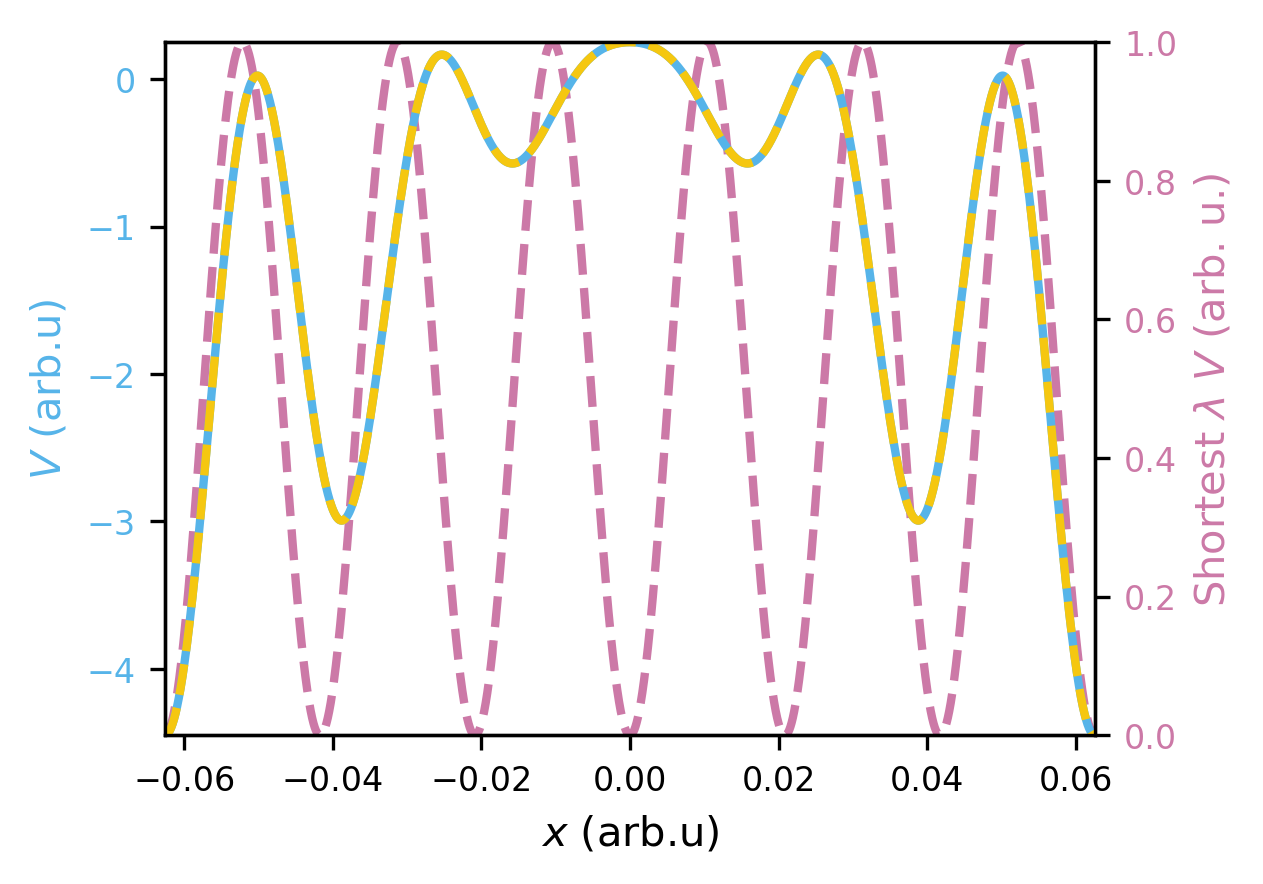

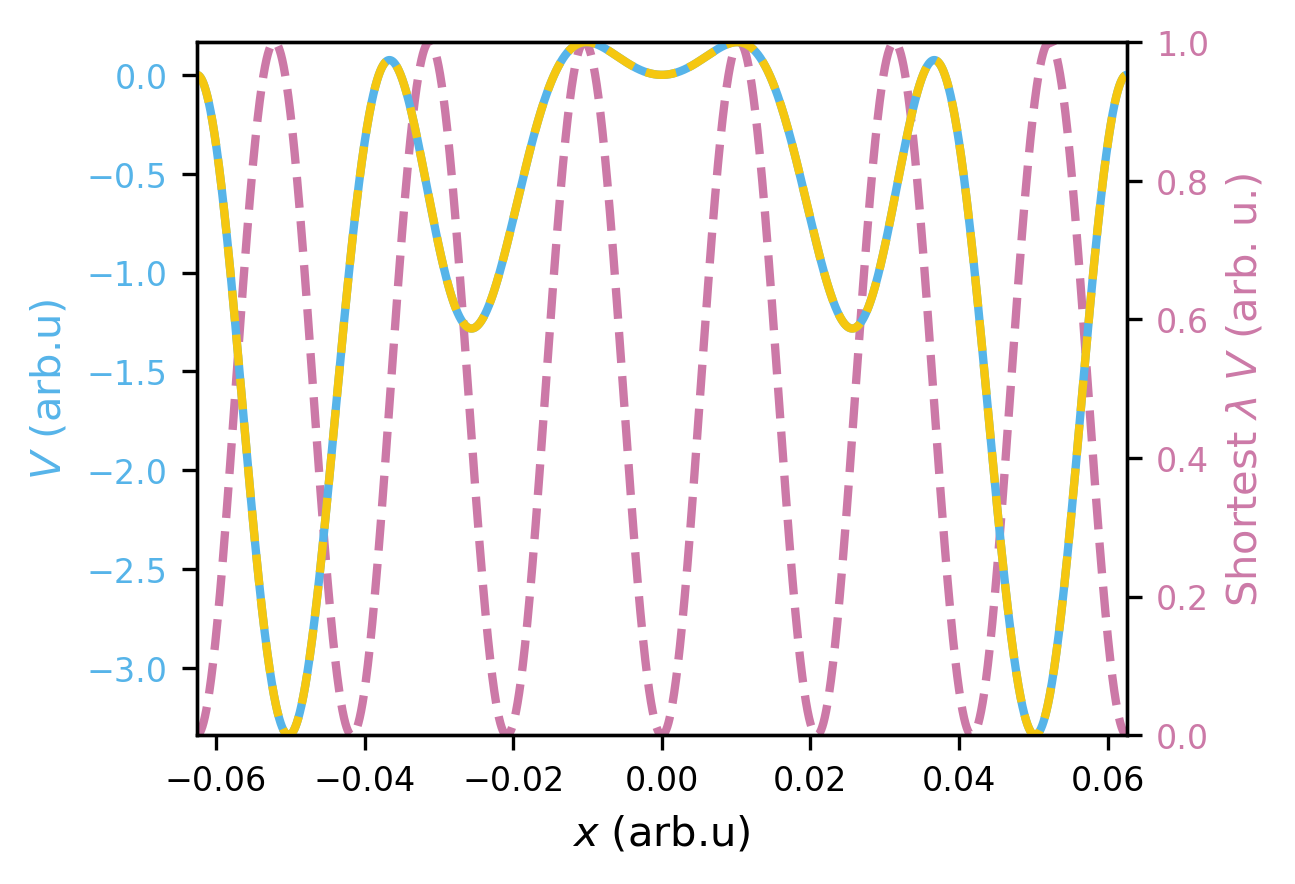

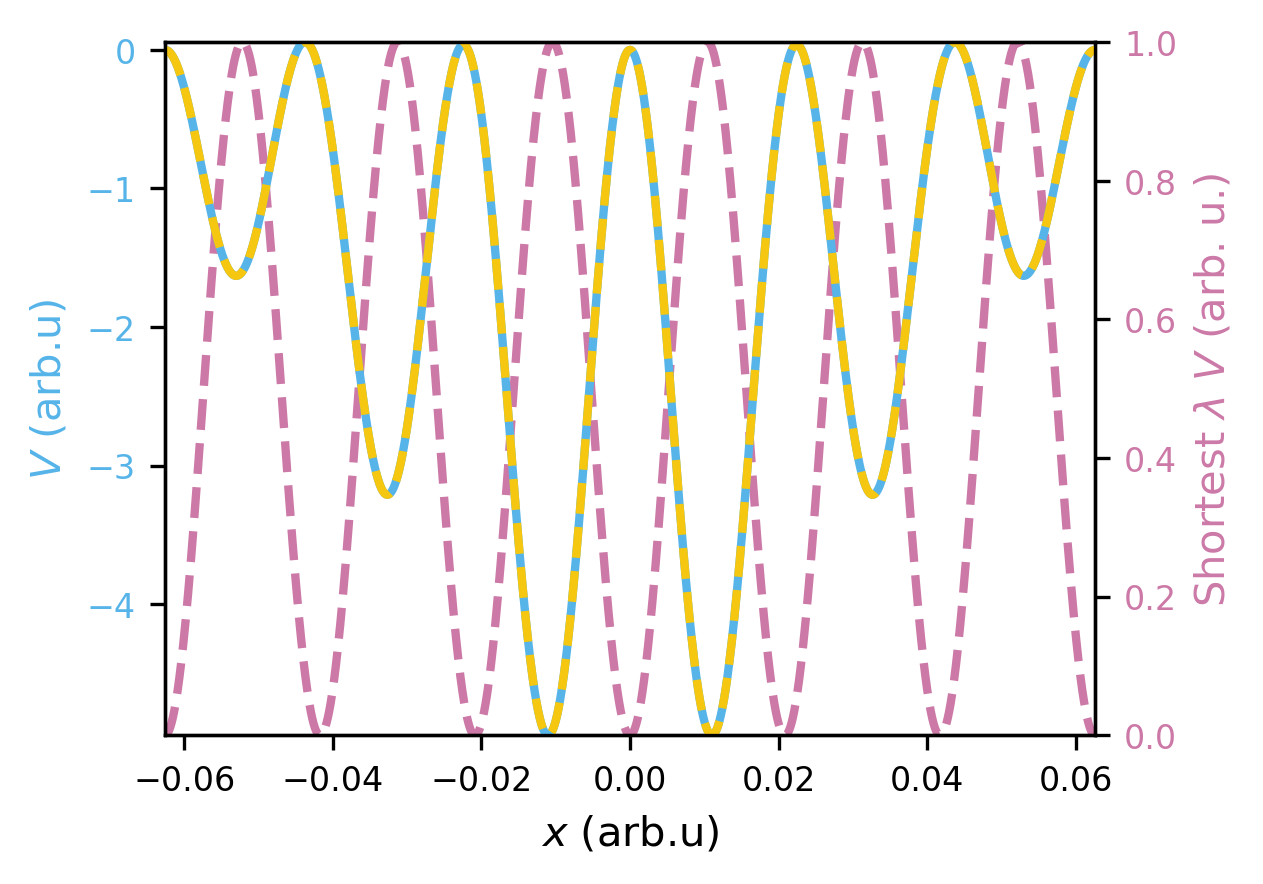

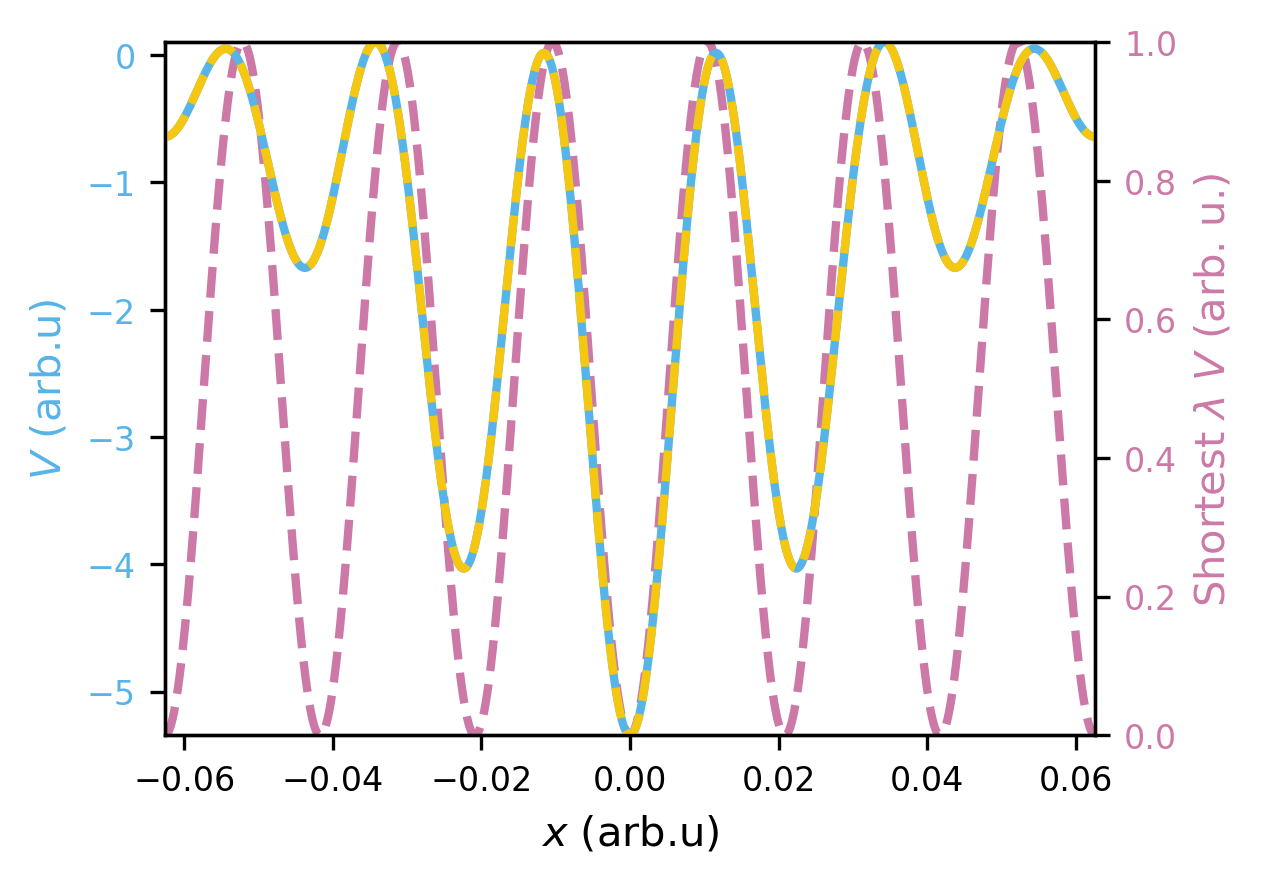

In [197]:
for _ in range(n*2):
    #fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(8, 3), dpi=300)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    eig_vector=vecs[:, _] 
    tector=vecss[:, _]
    rat_wind = 5
    tempV = -0.5 * np.array(α1 * (eig_vector[0] * f0 + eig_vector[1] * f1) ** 2 + α2 * (eig_vector[2] * f2 + eig_vector[3] * f3) ** 2
                     + (α1 + α2) * (eig_vector[0] * f0 + eig_vector[1] * f1) * (eig_vector[2] * f2 + eig_vector[3] * f3))
    tV = -0.5 * np.array(α1 * (tector[0] * f0 + tector[1] * f1) ** 2 + α2 * (tector[2] * f2 + tector[3] * f3) ** 2
                 + (α1 + α2) * (tector[0] * f0 + tector[1] * f1) * (tector[2] * f2 + tector[3] * f3))  
    ampl_ind = [int(0.5 * (len(x_full) - rat_wind * len(x))), int(0.5 * (len(x_full) + rat_wind * len(x)))]
    #ampl_ref = [min(tempV[ampl_ind[0]:ampl_ind[1]]), max(tempV[ampl_ind[0]:ampl_ind[1]])]
    ampl_ref = [min(tempV), max(tempV)]
    ax1.set_ylabel('$V$ (arb.u)', color=c1)
    ax1.plot(x_full, tempV, color=c1)
    ax1.plot(x_full, tV, color=c4, linestyle='--')
    ax1.tick_params(axis='y', labelcolor=c1)
    
    ax1.set_xlabel('$x$ (arb.u)')
    ax1.set_xlim(x_full[0], x_full[-1])

    ax2 = ax1.twinx() 

    ax2.plot(x_full, largest_freq_pulsez ** 2, color=c2, linestyle='--')

    ax1.set_ylim(ampl_ref[0], ampl_ref[1])
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('Shortest $\lambda$ $V$ (arb. u.)', color=c2)
    ax2.tick_params(axis='y', labelcolor=c2)
    ax1.set_zorder(1)
    ax1.patch.set_visible(False)
    plt.show()




# Stop here to verify optimal solution number before proceeding

In [198]:
#########################################################################
#
# After visually assessing optimal field, declare it here 
#
#########################################################################

eval = 2
winner_amps = vecss[:, eval]
eig_winner = -0.5 * np.array(α1 * (winner_amps[0] * E0 + winner_amps[1] * E1) ** 2 + α2 * (winner_amps[2] * E2 + winner_amps[3] * E3) ** 2
                      + (α1 + α2) * (winner_amps[0] * E0 + winner_amps[1] * E1) * (winner_amps[2] * E2 + winner_amps[3] * E3))
winner_zoom = -0.5 * np.array(α1 * (winner_amps[0] * f0 + winner_amps[1] * f1) ** 2 + α2 * (winner_amps[2] * f2 + winner_amps[3] * f3) ** 2
                       + (α1 + α2) * (winner_amps[0] * f0 + winner_amps[1] * f1) * (winner_amps[2] * f2 + winner_amps[3] * f3))

winner_combined_amps = np.array([Phi_combine_amps(winner_amps[_+1], winner_amps[_]) for _ in np.arange(0, len(eig_vector), 2)])
winner_combined_phases = np.array([Phi_combine_phases(winner_amps[_+1], winner_amps[_]) for _ in np.arange(0, len(eig_vector), 2)])

indv_fields = np.array([winner_combined_amps[_] * np.cos(k[_] * x_full - winner_combined_phases[_]) for _ in range(2)])


scalings = np.array([get_alpha(_) for _ in λ_control])
field_scalings = np.abs(scalings[:, 0])
field_orders = scalings[:,1]


print(winner_combined_amps)
print([np.sqrt(vecs[1, eval] ** 2 + vecs[0, eval] ** 2), np.sqrt(vecs[3, eval] ** 2 + vecs[2, eval] ** 2)])

[0.91108057 0.41222832]
[0.9110816503544465, 0.4122259409443054]


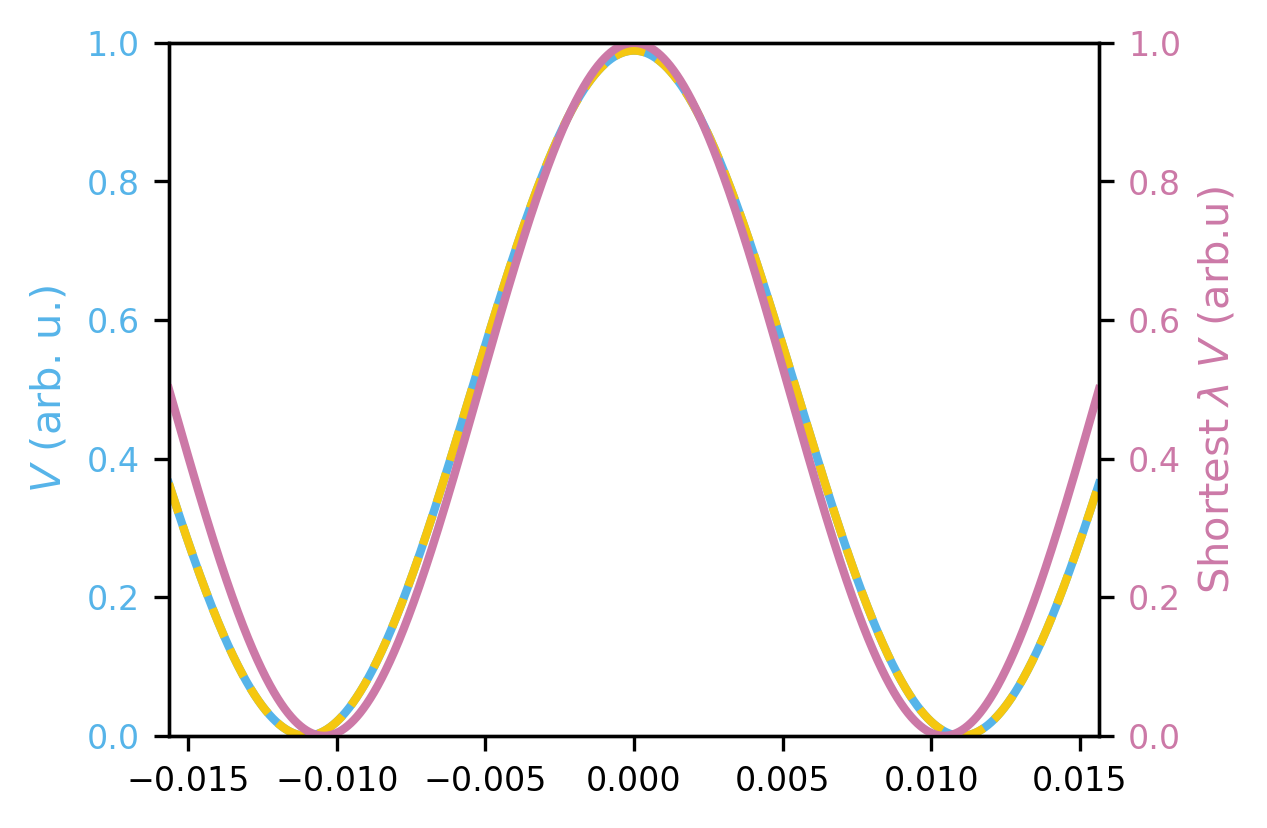

In [199]:
st1 = -0.5 * (α1 * indv_fields[0] ** 2 + α2 * indv_fields[1] ** 2 + (α1 + α2) * indv_fields[0] * indv_fields[1])
st2 = winner_zoom.copy()

st1 -= min(st1)
st1 /= max(st1)
st2 -= min(st2)
st2 /= max(st2)

st3 = Phi(x_full, max(k), phase=np.pi/2) ** 2


fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(x_full, st1, color=c1)
ax1.plot(x_full, st2, color=c4, linestyle='--')
ax1.set_xlim(1.5*gpe.dimless_x([-0.25*λ_min, 0.25*λ_min], -9))

ax2 = ax1.twinx()

ax2.plot(x_full, st3, color=c2)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax1.set_ylabel('$V$ (arb. u.)', color=c1)
ax1.tick_params(axis='y', labelcolor=c1)
ax2.set_ylabel('Shortest $\lambda$ $V$ (arb.u)', color=c2)
ax2.tick_params(axis='y', labelcolor=c2)  

plt.show()

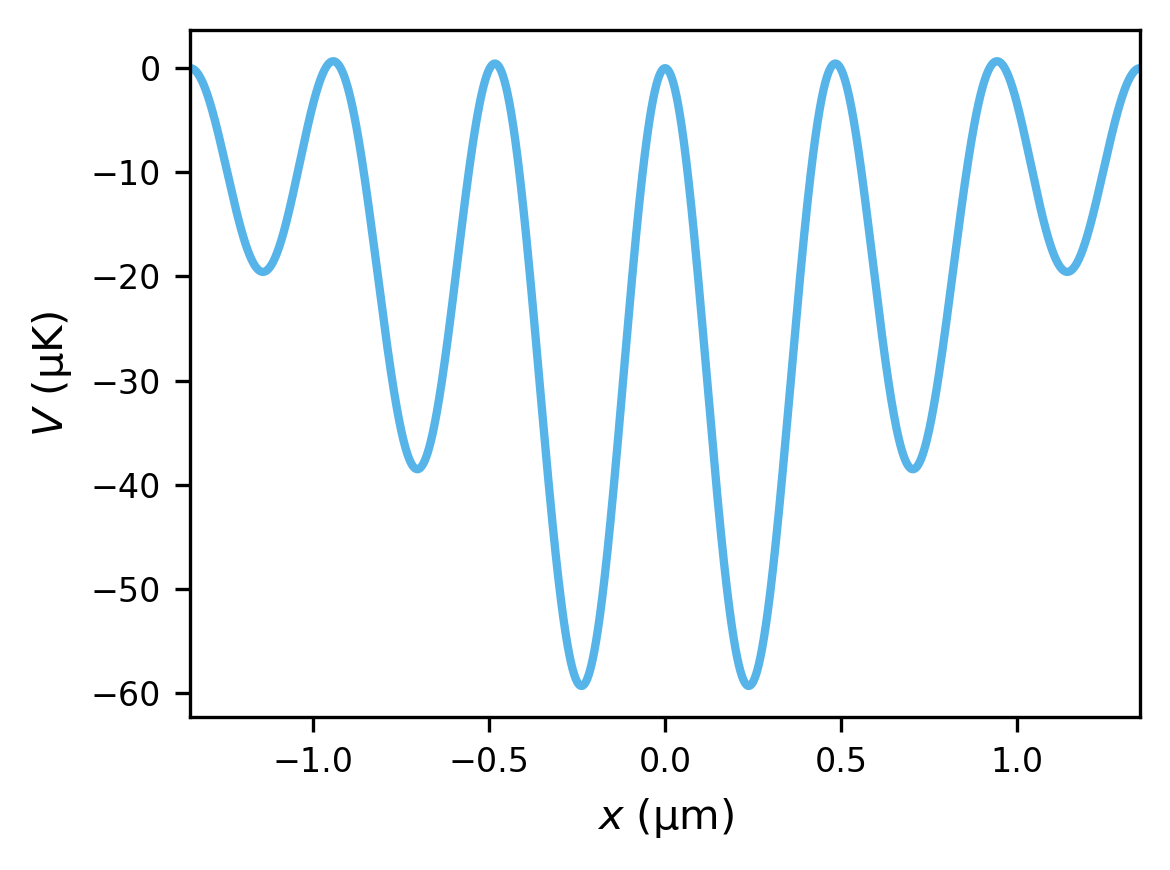

In [200]:
# Visual Assesment Modifier
vam = 1e16
winamps = winner_amps * np.sqrt(vam)
"""ae_winfull, ae_winfull_order = get_V(gpe.convert_x(x_full, 0), 
                               winner_combined_phases[0], winner_combined_phases[1], 
                               λ_control[0], λ_control[1],
                               winamps[0], winamps[1])
ae_win, ae_win_order = get_V(gpe.convert_x(x, 0), 
                               winner_combined_phases[0], winner_combined_phases[1], 
                               λ_control[0], λ_control[1],
                               winamps[0], winamps[1])"""


ae_winfull = -0.5 * vam * np.array(α1 * (winner_amps[0] * f0 + winner_amps[1] * f1) ** 2 + α2 * (winner_amps[2] * f2 + winner_amps[3] * f3) ** 2
                       + (α1 + α2) * (winner_amps[0] * f0 + winner_amps[1] * f1) * (winner_amps[2] * f2 + winner_amps[3] * f3))

ae_win = -0.5 * vam * np.array(α1 * (winner_amps[0] * E0 + winner_amps[1] * E1) ** 2 + α2 * (winner_amps[2] * E2 + winner_amps[3] * E3) ** 2
                      + (α1 + α2) * (winner_amps[0] * E0 + winner_amps[1] * E1) * (winner_amps[2] * E2 + winner_amps[3] * E3))



adjusted_eig_winner = ae_win.copy()
#adjusted_eig_winner -= min(adjusted_eig_winner)
adjusted_eig_winner *= 10 ** α2_order
adjusted_eig_zoom  = ae_winfull.copy()
#adjusted_eig_zoom = -1 * ae_winfull.copy()
#adjusted_eig_zoom -= min(adjusted_eig_zoom)
adjusted_eig_zoom *= 10 ** α2_order


plt.figure()
plt.plot(gpe.convert_x(x_full, -6), gpe.convert_energy(adjusted_eig_zoom, -6), color=c1)
plt.ylabel('$V$ (μK)')
plt.xlabel('$x$ (μm)')
plt.xlim(gpe.convert_x([x_full[0], x_full[-1]], -6))
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_AdjustedPotential.pdf')
plt.show()

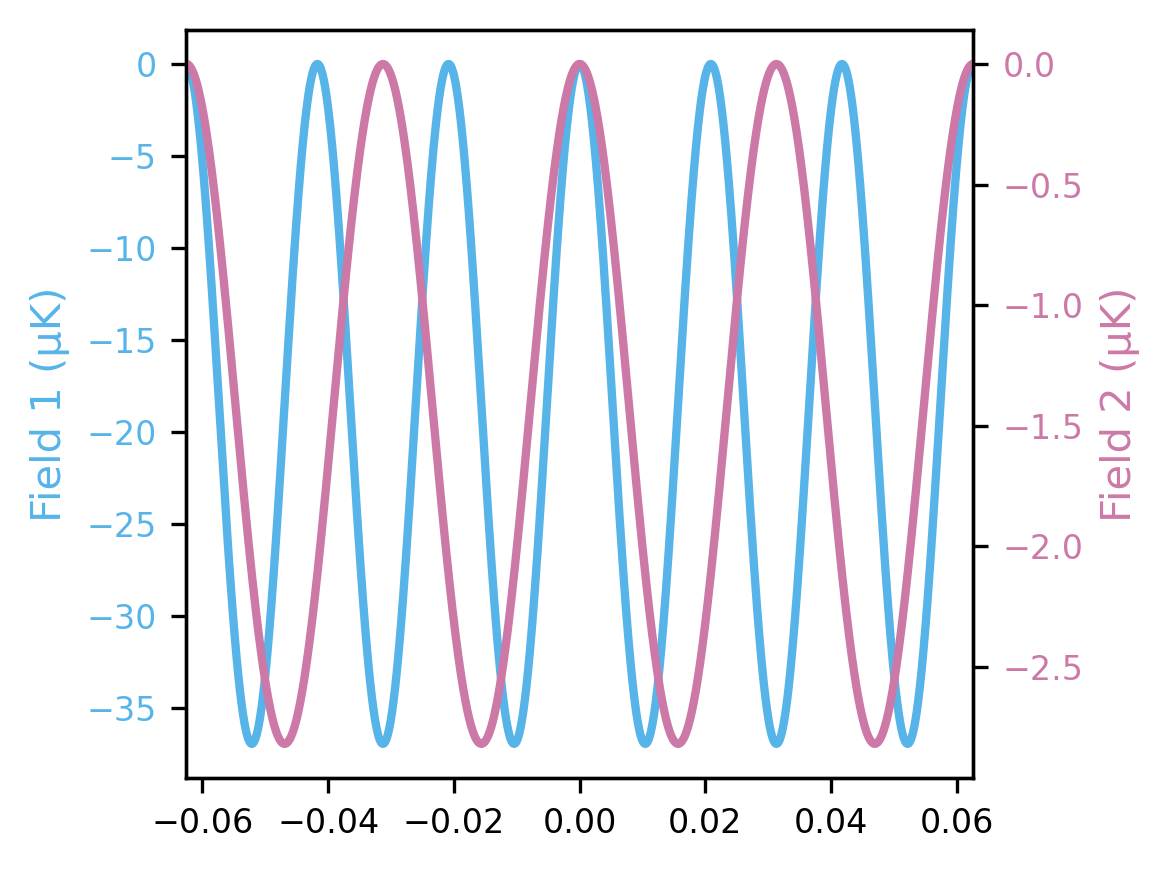

In [201]:
ff1 = -0.5 * α1 * (winamps[0] * f0 + winamps[1] * f1) ** 2
ff2 = -0.5 * α2 * (winamps[2] * f2 + winamps[3] * f3) ** 2

#ff1 -= min(ff1)
ff1 *= 10 ** α2_order
#ff2 -= min(ff2)
ff2 *= 10 ** α2_order

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x_full, gpe.convert_energy(ff1, -6), color=c1)
ax1.set_xlim(x_full[0], x_full[-1])

ax2 = ax1.twinx()
ax2.plot(x_full, gpe.convert_energy(ff2, -6), color=c2)

ax1.set_ylabel('Field 1 (μK)', color=c1)
ax1.tick_params(axis='y', labelcolor=c1)
ax2.set_ylabel('Field 2 (μK)', color=c2)
ax2.tick_params(axis='y', labelcolor=c2)  
plt.tight_layout()
plt.show()

## Below is the BEC section. Please declare the field you wish to use.

In [165]:
########################################################################################################################
# The field goes here
########################################################################################################################


tags_opts = f'EigenSolution_{eval}'


op = 2


test_field_so_window, test_field_full = [adjusted_eig_winner, adjusted_eig_zoom]

test_field_so_window -= test_field_so_window.min()
test_field_full -= test_field_full.min()

test_field_tag = tags_opts

# Coordinates are declared as z for ease of reading
# Coordinate x is still used when viewing SO window
dz = dx
z = x_full
z_micro = gpe.convert_x(x_full, -6)
z_nano = gpe.convert_x(x_full, -9)
T = 10
times = np.linspace(0, T, 500)

# Potentials as "functions"
VV = UnivariateSpline(z, test_field_full, s=0)
vv = UnivariateSpline(x, test_field_so_window, s=0)


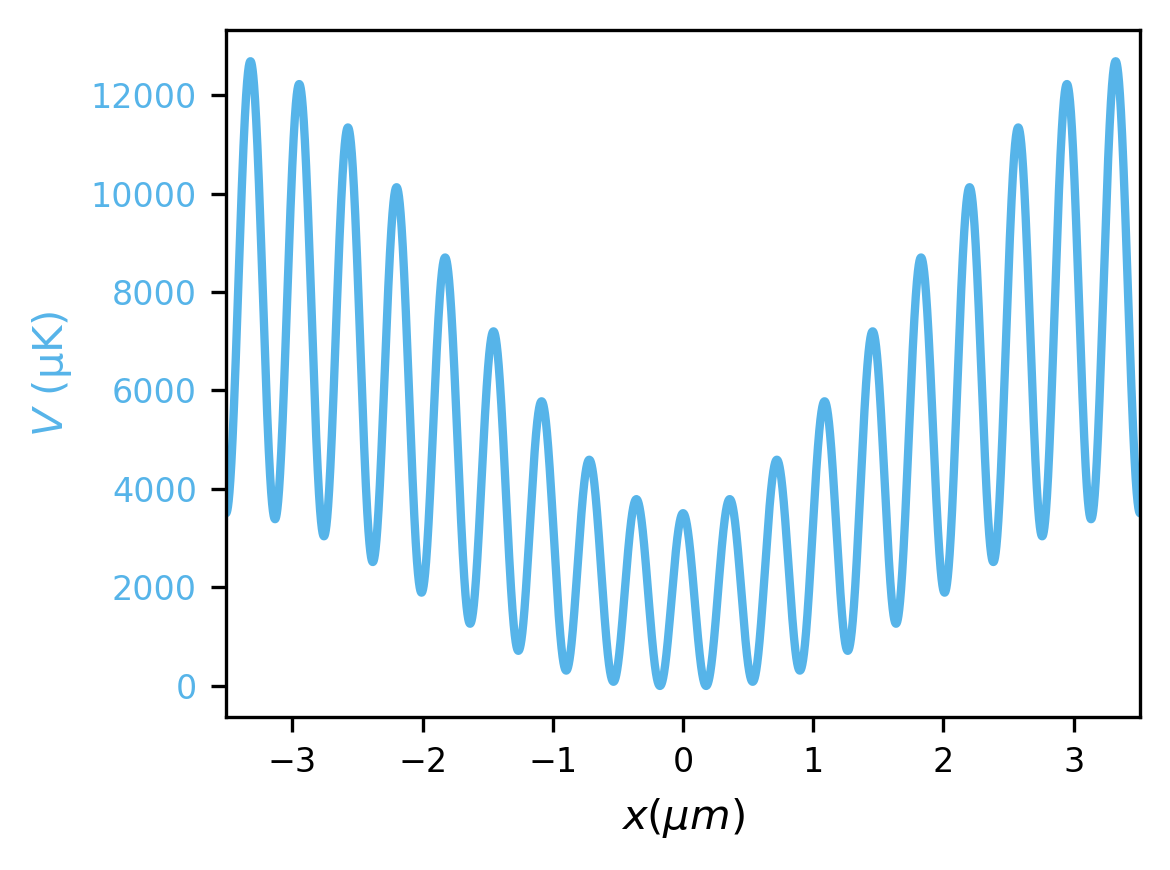

In [166]:
########################################################################################################################
# Get the BEC
########################################################################################################################


@njit
def diff_k(p):
    """
    the derivative of the kinetic energy for Ehrenfest theorem evaluation
    """
    return p


@njit(parallel=True)
def ke(p):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2
    
suggestion_slope = 1 # 1 / (2 * np.pi)
suggestion_sin = Phi(z, np.pi / (2 * x_lim), amplitude=2*ampl) ** 2

dimless_Tc = gpe.dimless_energy(T_c, -9)


@njit(parallel=True)
def first_pass_cooling(x):
    """
    Non-relativistic kinetic energy
    """
    return max(adjusted_eig_winner) * (x / x_lim) ** 2

def fwhm(density, grid):
    index = np.where(density >= 0.5*density.max())[0]
    return grid[index[-1]] - grid[index[0]], [grid[index[0]], grid[index[-1]]]

first_pass_params = dict(
    x_amplitude=x_lim,
    x_grid_dim=x_res,
    N=N,
    k=ke,
    initial_trap=first_pass_cooling,
    times=times,
    diff_k=diff_k,
    get_mu=True,
)

sys_params = dict(
    x_amplitude=x_lim,
    x_grid_dim=x_res,
    N=N,
    k=ke,
    initial_trap=VV,
    times=times,
    diff_k=diff_k,
    get_mu=True,
)


fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(z_micro, gpe.convert_energy(sys_params['initial_trap'](z), -6), label='SO Potential', color=c1)
ax1.set_xlabel('$x (μm)$')
ax1.set_xlim(z_micro[0], z_micro[-1])

if pre_cooling:
    ax2 = ax1.twinx()
    ax2.plot(z_micro, gpe.convert_energy(first_pass_cooling(z), -6), label='Initial Cooling Potential', color=c2)
    ax2.set_ylabel('Inititial Cooling Potential (μK)', color=c2)
    ax2.tick_params(axis='y', labelcolor=c2)

ax1.set_ylabel('$V$ (μK)', color=c1)
ax1.tick_params(axis='y', labelcolor=c1)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-1e-4, 1e-4))
plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_CoolingPotential_{test_field_tag}.pdf')
plt.show()

#plt.figure()
#plt.plot(z_nano, gpe.convert_energy(sys_params['initial_trap'](z), -9))
#plt.xlim(-λ_min, λ_min)
#plt.ylim(0, 2 * max(gpe.convert_energy(sys_params['initial_trap'](x), -9)))
#plt.show()

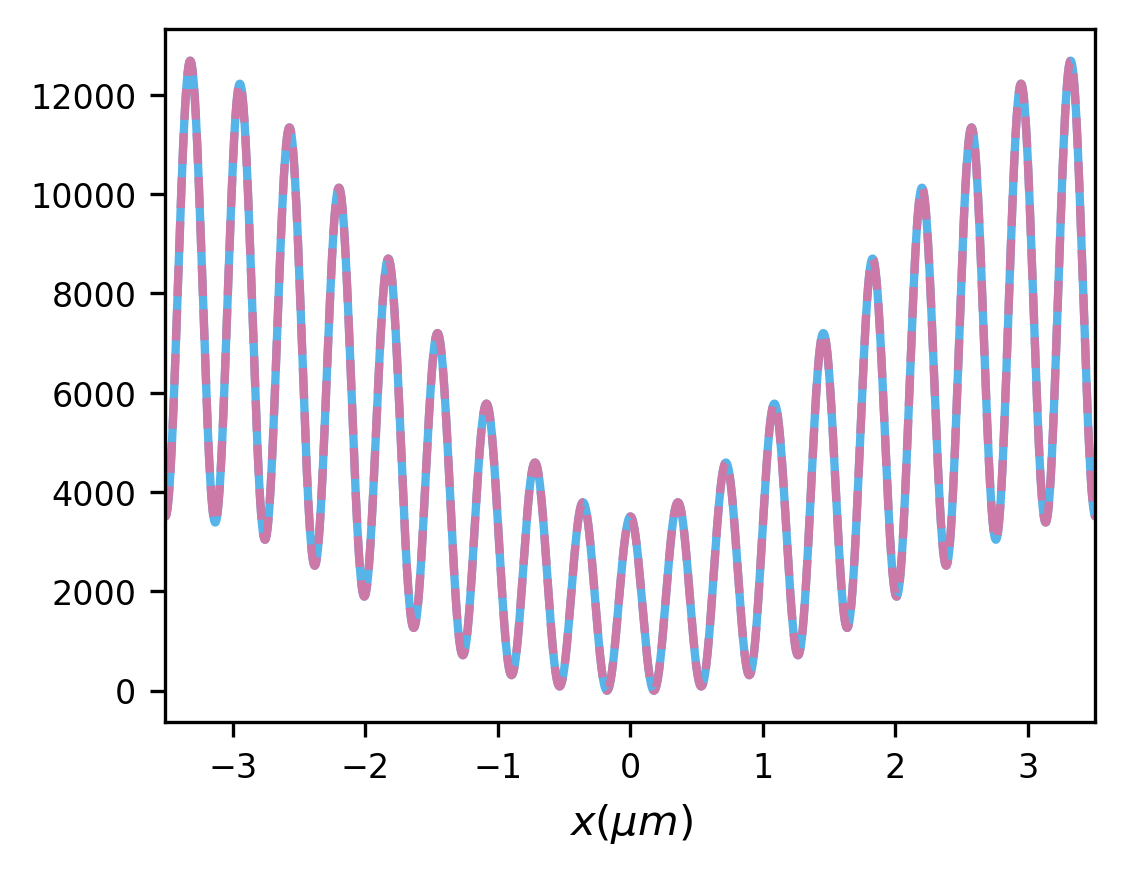

In [167]:
U_left = 0.5 * gpe.convert_energy(sys_params['initial_trap'](z), -6)
U_right = 0.5 * gpe.convert_energy(sys_params['initial_trap'](-1*z), -6)
U_2 = U_left + U_right
plt.plot(z_micro, gpe.convert_energy(sys_params['initial_trap'](z), -6), label='SO Potential', color=c1)
plt.plot(z_micro, U_2, label='Counterpropagating Potentials', color=c2, linestyle='--')
plt.xlabel('$x (μm)$')
plt.xlim(z_micro[0], z_micro[-1])
plt.show()

In [168]:
if pre_cooling:
    init_state, E, mu = imag_time_gpe1D(
        v=first_pass_params['initial_trap'],
        g=g,
        dt=1e-6,
        epsilon=1e-8,
        **sys_params
    )
    
    init_state, E, mu = imag_time_gpe1D(
        v=first_pass_params['initial_trap'],
        g=g,
        init_wavefunction=init_state,
        dt=1e-8,
        epsilon=1e-10,
        **sys_params
    )
    
    print(f'Initial BEC Energy: {gpe.convert_energy(E, -9)} nK')
    print(f'This compared to the Critical Temperature:  {T_c} nK')

In [169]:
if pre_cooling:
    init_state, E, mu = imag_time_gpe1D(
        init_wavefunction=init_state,
        v=sys_params['initial_trap'],
        g=g,
        dt=1e-6,
        epsilon=1e-8,
        **sys_params
    )

else:
    init_state, E, mu = imag_time_gpe1D(
        v=sys_params['initial_trap'],
        g=g,
        dt=1e-6,
        epsilon=1e-8,
        **sys_params
    )

init_state, E, mu = imag_time_gpe1D(
    v=sys_params['initial_trap'],
    g=g,
    init_wavefunction=init_state,
    dt=1e-8,
    epsilon=1e-10,
    **sys_params
)

print(f'Initial BEC Energy: {gpe.convert_energy(E, -9)} nK')
print(f'This compared to the Critical Temperature:  {T_c} nK')

assert gpe.convert_energy(E, -9) < T_c, "This is not a BEC!, T > T_c"



Starting imaginary time propagation
current ground state energy = 3.8498e+06


Final ground state energy = 3.8320e+06
Final Chemical potential = 4.3134e+06

Starting imaginary time propagation
current ground state energy = 3.3206e+06


Final ground state energy = 2.7361e+06
Final Chemical potential = 3.1379e+06
Initial BEC Energy: 32827.517123327554 nK
This compared to the Critical Temperature:  66111.54888998118 nK


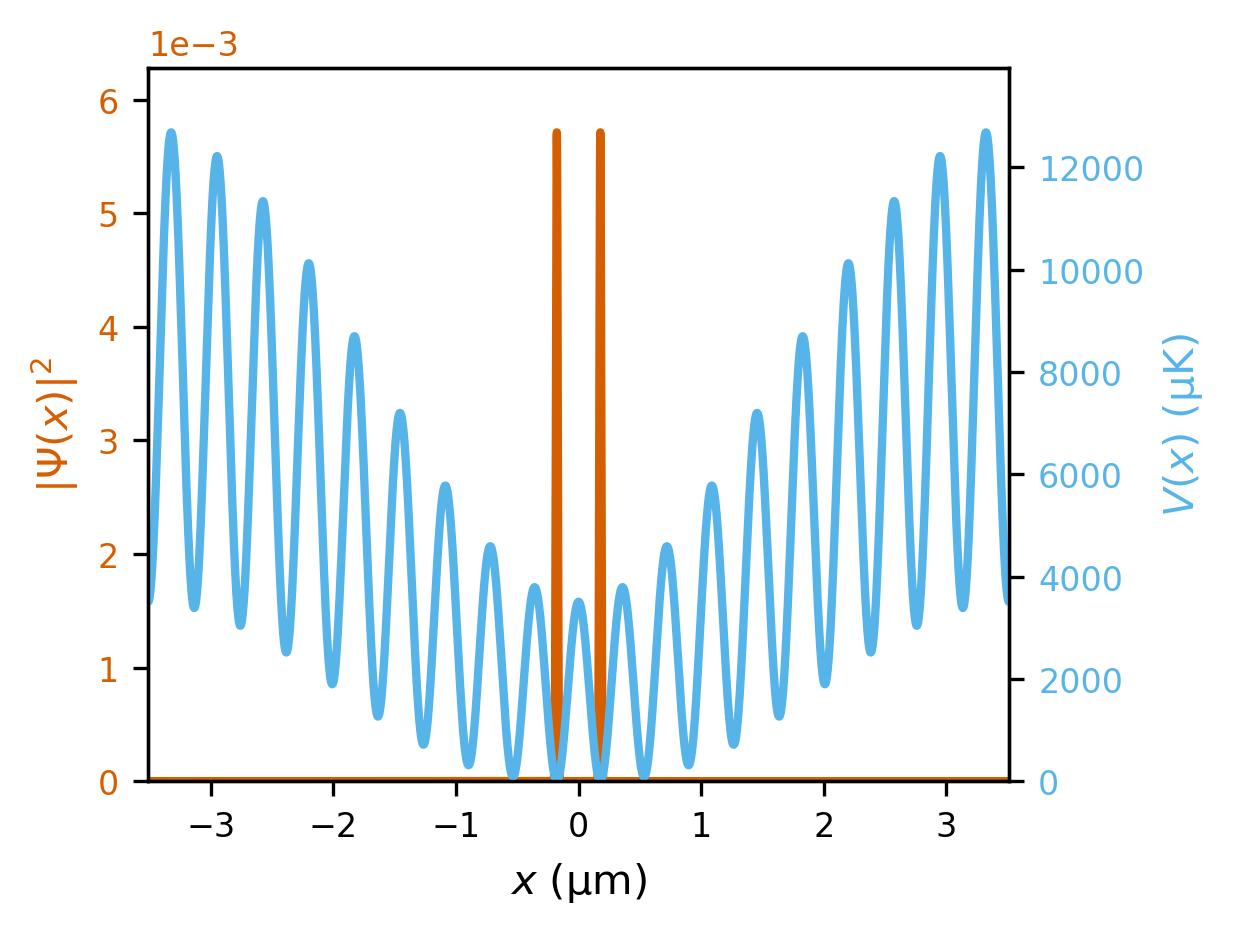

Sanity Check, the density is: 0.9999999999999998


In [170]:
density = np.abs(init_state) ** 2 * dz
pmax = 1.1 * gpe.convert_energy(sys_params['initial_trap'](z), -6).max()
pmin = 0.95 * gpe.convert_energy(sys_params['initial_trap'](z), -6).min()

fig = plt.figure(layout='constrained')
ax1 = fig.add_subplot(111)
ax1.plot(z_micro, density, color=c5)
ax1.set_xlim(z_micro[0], z_micro[-1])
ax1.set_xlabel('$x$ (μm)')

ax2 = ax1.twinx()

ax2.plot(z_micro, gpe.convert_energy(sys_params['initial_trap'](z), -6), color=c1)
#ax2.vlines([-1.25*λ_min/4*1e-3, 1.25*λ_min/4*1e-3], 0, pmax, linestyle='--', color=ok['black'], linewidth=1)

ax1.set_ylim(0, 1.1 * density.max())
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0, 1e-4))
ax2.set_ylim(0, pmax)

ax1.set_ylabel('$|\\Psi(x)|^2$', color=c5)
ax1.tick_params('y', labelcolor=c5)
ax2.set_ylabel('$V(x)$ (μK)', color=ok['blue'])
ax2.tick_params('y', labelcolor=ok['blue'])
#plt.tight_layout()
plt.savefig(f'{file_path}/{file_name}_Potential-and-Density_{test_field_tag}.pdf')
#plt.savefig(f'{file_path}/{file_name}_Potential-and-Density-Lines_{test_field_tag}.pdf')
plt.show()

print(f'Sanity Check, the density is: {np.sum(density)}')

In [171]:
plot_max = gpe.convert_energy(max(sys_params['initial_trap'](x)), -9)
plot_min = gpe.convert_energy(min(sys_params['initial_trap'](x)), -9)

# Input required for peak sectioning

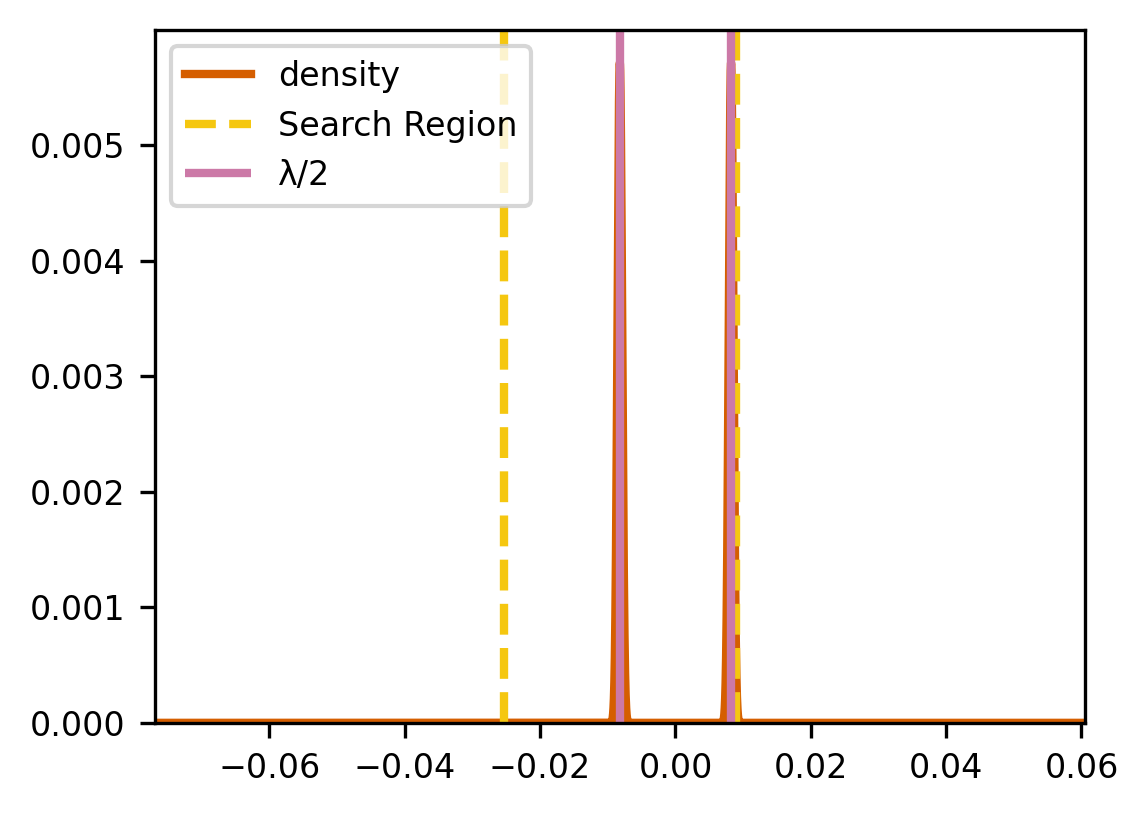

-2.0375368059433185e-13
Density peaks at 0.005711564469696259, while the 2x minimum density at separations is 8.381954771533964e-38


In [172]:
# Plot the interest area to verify the density peaks are contained entirely within
density_func = UnivariateSpline(z, density, s=0)
center_peak_loc= z[density_func(z)[0:int(len(z) *0.5)].argmax()]
pixi = center_peak_loc - 0.5*(np.pi/k[0]+np.pi/k[1])
pixf = center_peak_loc + 0.5*(np.pi/k[0]+np.pi/k[1]) # 0.5gpe.dimless_x(min(λ_control), -9) #

plt.plot(z, density, color=c5, label='density')
plt.vlines([pixi, pixf], 0, 1.2*density.max(), color=c4, linestyle='--', label='Search Region')
plt.vlines([gpe.dimless_x(-λ_min/4, -9), gpe.dimless_x(λ_min/4, -9)], 0, plot_max, color=c2, label='λ/2')
plt.xlim(center_peak_loc- 2*(np.pi/k[0]+np.pi/k[1]), center_peak_loc+ 2*(np.pi/k[0]+np.pi/k[1]))
plt.ylim(0, 1.05*density.max())
plt.legend()
plt.show()

centerpoint=int(0.5*len(z))
print(z[centerpoint])
            
# Quick check on maxes vs peak separation
print(f'Density peaks at {density.max()}, while the 2x minimum density at separations is {2 * density_func(z[centerpoint])}')

[-0.008621565605086895, 0.008621565604679388]


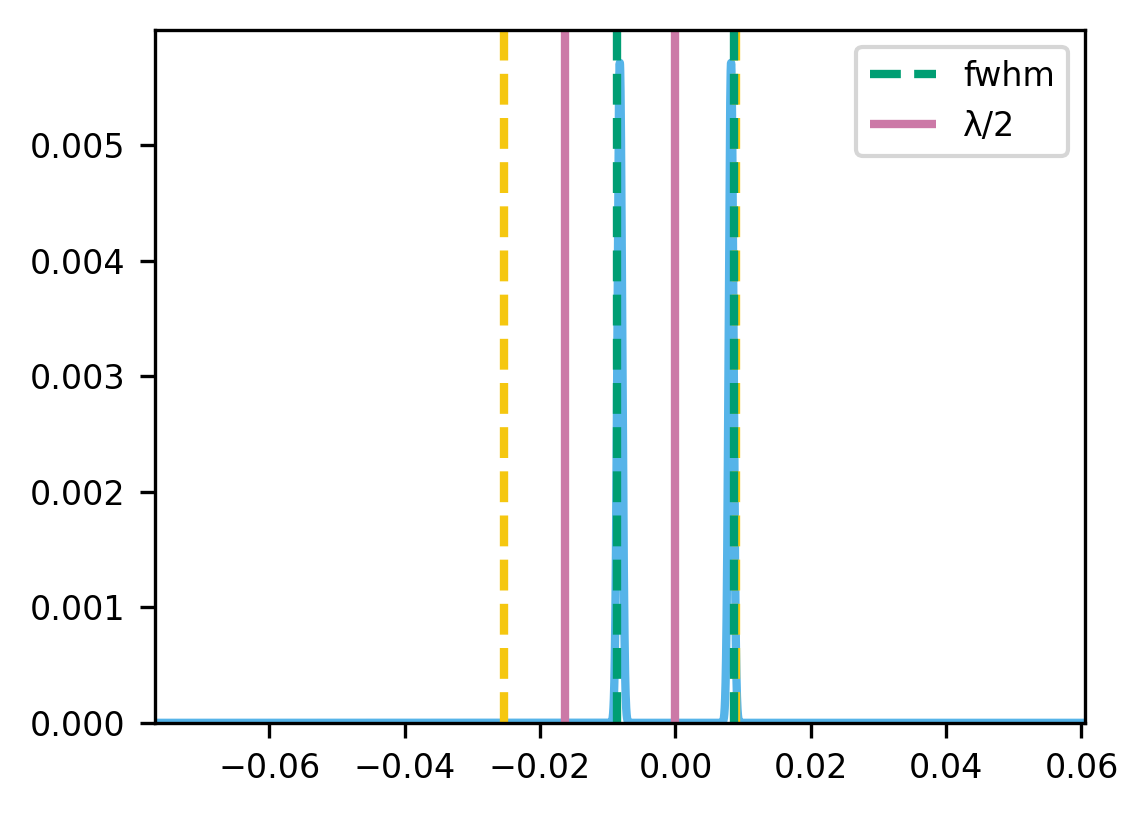

In [173]:
# Perform Full Width, Half Max Calculation after seeing density
spi = [np.where(z >= pixi)[0][0], np.where(z <= pixf)[0][-1]]
width, x_width = fwhm(density[spi[0]:spi[-1]], z[spi[0]:spi[-1]])
print(x_width)


center = gpe.convert_x(center_peak_loc, -9)

plt.figure()
plt.plot(z, density, color=c1)
plt.vlines([pixi, pixf], 0, 1.2*density.max(), color=c4, linestyle='--')
plt.vlines([x_width[0], x_width[1]], 0, 1.2*density.max(), color=c3, linestyle='--', label='fwhm')
plt.vlines([gpe.dimless_x(center-λ_min/4, -9), gpe.dimless_x(center+λ_min/4, -9)], 0, plot_max, color=c2, label='λ/2')
plt.xlim(center_peak_loc- 2*(np.pi/k[0]+np.pi/k[1]), center_peak_loc+ 2*(np.pi/k[0]+np.pi/k[1]))
plt.ylim(0, 1.05*density.max())
plt.legend()
plt.show()

In [174]:
# Now perform peak highlighting
n_peaks = 2
peaks_sectioning = np.linspace(pixi, 0, n_peaks)


interest_areas = [(np.array(z)[(z>=_) & (z<(_+(pixf - pixi)/n_peaks))]) for _ in peaks_sectioning]
peak_locations = [_[density_func(_).argmax()] for _ in interest_areas]
confinement_distance = [np.abs(peak_locations[_+1]-peak_locations[_]) for _ in range(len(peak_locations)-1)]
print(f'Peaks are located at: {peak_locations}')
print(f'Distances between these peaks are: {gpe.convert_x(confinement_distance, -9)} nm')
print(f'The confinement limit is half the field wavelength: {0.5 * λ_min} nm')
print(f'To confine beyond the transition frequency, distance must be under {0.5 * principal_wavelength} nm')

Peaks are located at: [-0.008234191113623252, 0.008224258433947446]
Distances between these peaks are: [354.98474121] nm
The confinement limit is half the field wavelength: 351.0 nm
To confine beyond the transition frequency, distance must be under 390.125605 nm


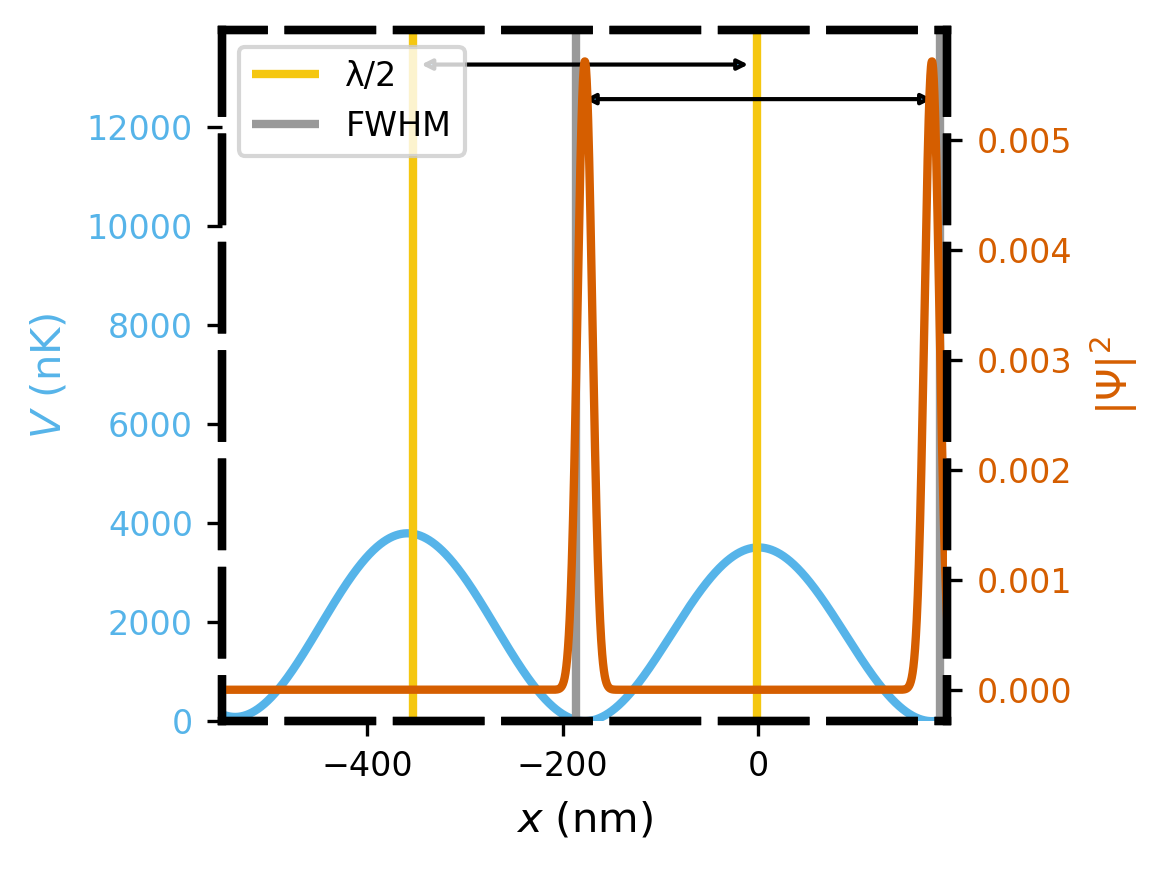

In [175]:
"""
Run this cell for confinement
"""
plot_min = pmin
plot_max = pmax

fig=plt.figure()
ax1=fig.add_subplot(111)
plt.setp(ax1.spines.values(), linewidth=2, linestyle=(5, (10, 3)))

ax1.plot(gpe.convert_x(z, -9), gpe.convert_energy(sys_params['initial_trap'](z), -6))
ax1.vlines([center-λ_min/4, center+λ_min/4], 0, plot_max, color=ok['amber'], label='λ/2')
ax1.vlines(gpe.convert_x(x_width, -9), 0, plot_max, color=ok['grey'], label='FWHM')
ax1.add_patch(patches.FancyArrowPatch(
    (center-λ_min/4, 0.95*plot_max), 
    (center+λ_min/4, 0.95*plot_max), 
     arrowstyle='<|-|>', mutation_scale=5)).set_zorder(3)
ax1.add_patch(patches.FancyArrowPatch(
    (gpe.convert_x(x_width[0], -9), 0.9*plot_max), 
    (gpe.convert_x(x_width[1], -9), 0.9*plot_max), 
    arrowstyle='<|-|>', mutation_scale=5)).set_zorder(5)


ax1.set_xlim(gpe.convert_x([pixi, pixf], -9))

ax2 = ax1.twinx()
plt.setp(ax2.spines.values(), linewidth=2, linestyle=(5, (10, 3)))
ax2.plot(gpe.convert_x(z, -9), density, color=c5, zorder=0)

ax1.set_ylim(plot_min, plot_max)
ax1.legend(loc='upper left')

ax1.set_ylabel('$V$ (nK)', color=ok['blue'])
ax1.tick_params('y', labelcolor=ok['blue'])

ax2.set_ylabel('$|\\Psi|^2$', color=c5)
ax2.tick_params('y', labelcolor=c5)

ax1.set_xlabel('$x$ (nm)')
plt.savefig(f'{file_path}/{file_name}_ResultsWithFWHM_{test_field_tag}.pdf')
plt.tight_layout()
plt.show()

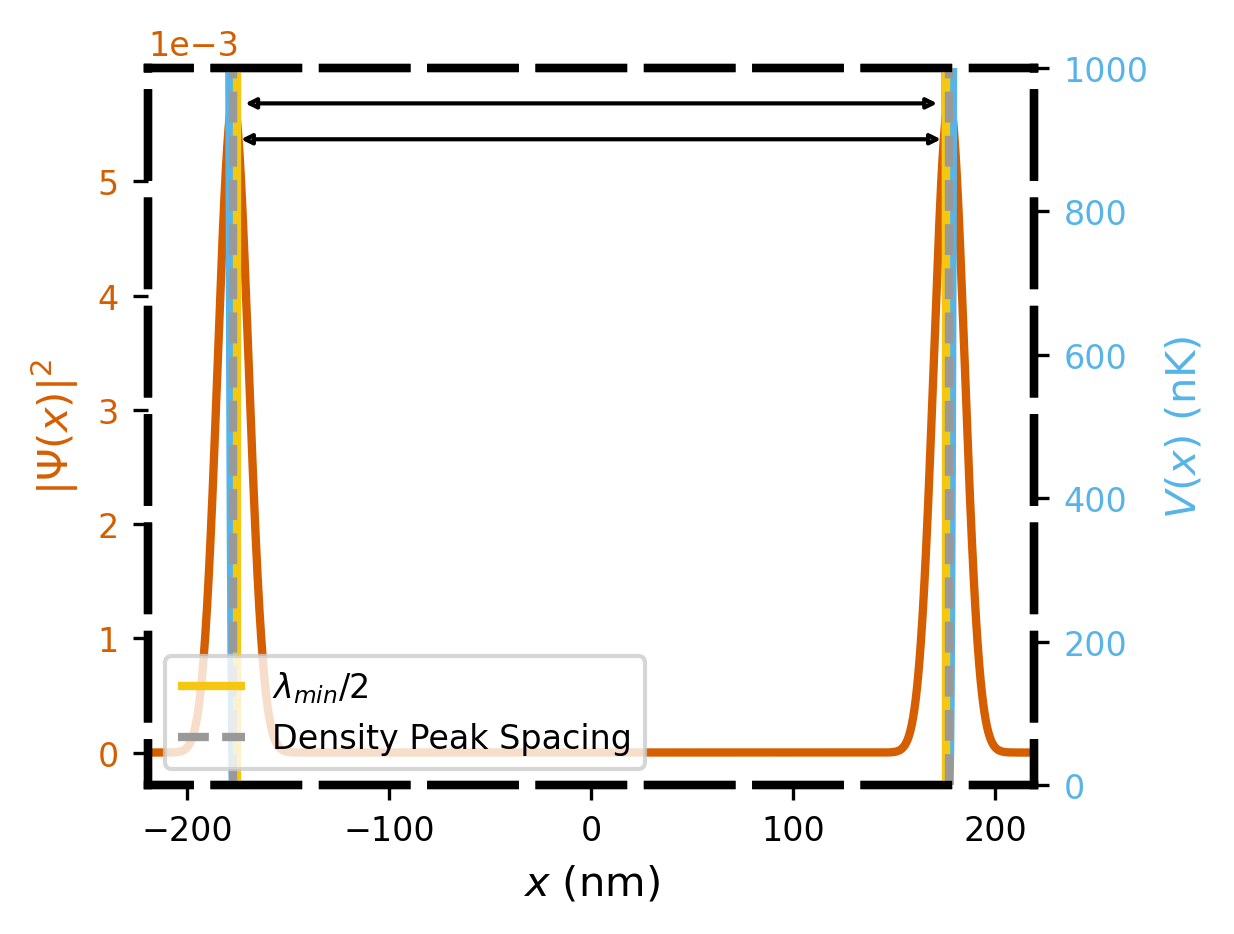

In [176]:
"""
Run this cell for peak seperation
"""
plot_min = 0
plot_max = 1000
fig=plt.figure(layout='constrained')
ax1=fig.add_subplot(111)
ax1.plot(gpe.convert_x(z, -9), density, color=c5, zorder=0)

ax1.set_xlim(-1.25*λ_min/4, 1.25*λ_min/4)
plt.setp(ax1.spines.values(), linewidth=2, linestyle=(5, (10, 3)))

ax2 = ax1.twinx()
plt.setp(ax2.spines.values(), linewidth=2, linestyle=(5, (10, 3)))
ax2.plot(gpe.convert_x(z, -9), gpe.convert_energy(sys_params['initial_trap'](z), -9))
ax2.vlines([-λ_min/4, λ_min/4], 0, plot_max, color=ok['amber'], label='$λ_{min}$/2')
ax2.vlines(gpe.convert_x(peak_locations, -9), 0, plot_max, color=ok['grey'], linestyle='--', label='Density Peak Spacing')
ax2.add_patch(patches.FancyArrowPatch(
    (-λ_min/4, 0.95*plot_max), 
    (λ_min/4, 0.95*plot_max), 
     arrowstyle='<|-|>', mutation_scale=5)).set_zorder(3)
ax2.add_patch(patches.FancyArrowPatch(
    (gpe.convert_x(peak_locations[0], -9), 0.9*plot_max), 
    (gpe.convert_x(peak_locations[1], -9), 0.9*plot_max), 
    arrowstyle='<|-|>', mutation_scale=5)).set_zorder(4)



ax2.set_ylim(plot_min, plot_max)
ax2.legend(loc='lower left').set_zorder(10)
ax2.set_ylabel('$V(x)$ (nK)', color=ok['blue'])
ax2.tick_params('y', labelcolor=ok['blue'])

ax1.set_ylabel('$|\\Psi(x)|^2$', color=c5)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0, 1e-4))
ax1.tick_params('y', labelcolor=c5)

ax1.set_xlabel('$x$ (nm)')
plt.savefig(f'{file_path}/{file_name}_ResultsWithPeaks_{test_field_tag}.pdf')
plt.show()

In [ ]:
# As a final step, get the amplitude in units of both Joules per alpha and nK per alpha
A_1 = np.sqrt(winamps[0] ** 2 + winamps[1] ** 2)
A_2 = np.sqrt(winamps[2] ** 2 + winamps[3] ** 2)
print(f'The amplitudes in dimensionless units are {A_1} and {A_2}')
A_1_sqJ = gpe.convert_energy(A_1 ** 2, 0, units='J')
A_2_sqJ = gpe.convert_energy(A_2 ** 2, 0, units='J')
A_1_sqK = gpe.convert_energy(A_1 ** 2, 0, units='K')
A_2_sqK = gpe.convert_energy(A_2 ** 2, 0, units='K')

spaced_out = gpe.convert_x(confinement_distance, -9)[0]
space_ratio = spaced_out / (0.5 * λ_min)

print(f'The amplitudes squared in Joules per units alpha are {A_1_sqJ} and {A_2_sqJ}')
print(f'The amplitudes squared in Kelvin per units alpha are {A_1_sqK} and {A_2_sqK}')
print(f"The maximum height of the potential is {gpe.convert_energy(sys_params['initial_trap'](z), -6).max()} μK")
print(f"The maximum height of the potential is {gpe.convert_energy(sys_params['initial_trap'](x), -9).max()} nK")
print(f"The spacing between peaks is {spaced_out} nm, or roughly {round(space_ratio, 4)}*λ_min")
print(f"Also of note is the ratio to the transition wavelength {round(spaced_out / (0.5 * principal_wavelength), 3)}*λ_0")

## Old Code below here in case it becomes useful again